Modelling with RFE n = 20

In [1]:
# Base Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import time
from collections import defaultdict

# Data Analysis Libraries
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFE, SelectKBest, mutual_info_classif, RFECV
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler, MaxAbsScaler, LabelEncoder, OneHotEncoder, PowerTransformer
from sklearn.metrics import mean_squared_error,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, RepeatedKFold, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
csv_file = 'CICDDoS-Real/cicddos2019_cleaned.csv'
df = pd.read_csv(csv_file, low_memory=False)
df.shape

(360000, 88)

In [3]:
# Mengacak seluruh baris DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

### Informasi Dataset

In [4]:
#info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360000 entries, 0 to 359999
Data columns (total 88 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   360000 non-null  int64  
 1   Flow ID                      360000 non-null  object 
 2   Source IP                    360000 non-null  object 
 3   Source Port                  360000 non-null  int64  
 4   Destination IP               360000 non-null  object 
 5   Destination Port             360000 non-null  int64  
 6   Protocol                     360000 non-null  int64  
 7   Timestamp                    360000 non-null  object 
 8   Flow Duration                360000 non-null  int64  
 9   Total Fwd Packets            360000 non-null  int64  
 10  Total Backward Packets       360000 non-null  int64  
 11  Total Length of Fwd Packets  360000 non-null  float64
 12  Total Length of Bwd Packets  360000 non-null  float64
 13 

In [5]:
#Bagian awal dataset
df.head()

Unnamed: 0                                 Flow ID   Source IP  \
0       28102    172.16.0.5-192.168.50.1-553-11930-17  172.16.0.5   
1       17675     172.16.0.5-192.168.50.1-997-4051-17  172.16.0.5   
2      661545    172.16.0.5-192.168.50.1-27238-3411-6  172.16.0.5   
3      688385   172.16.0.5-192.168.50.1-36181-39435-6  172.16.0.5   
4       16016  172.16.0.5-192.168.50.1-35261-14404-17  172.16.0.5   

   Source Port Destination IP  Destination Port  Protocol  \
0          553   192.168.50.1             11930        17   
1          997   192.168.50.1              4051        17   
2        27238   192.168.50.1              3411         6   
3        36181   192.168.50.1             39435         6   
4        35261   192.168.50.1             14404        17   

                    Timestamp  Flow Duration  Total Fwd Packets  ...  \
0  2018-12-01 11:23:04.133911              1                  2  ...   
1  2018-12-01 11:32:18.205323              2                  2  ...   
2  2018-12-01 13:31:10.155752              1                  2  ...   
3  2018-12-01 13:30:48.279274             51                  2  ...   
4  2018-12-01 13:02:49.155721         105961                  4  ...   

   Active Std  Active Max  Active Min  Idle Mean  Idle Std  Idle Max  \
0         0.0         0.0         0.0        0.0       0.0       0.0   
1         0.0         0.0         0.0        0.0       0.0       0.0   
2         0.0         0.0         0.0        0.0       0.0       0.0   
3         0.0         0.0         0.0        0.0       0.0       0.0   
4         0.0         0.0         0.0        0.0       0.0       0.0   

   Idle Min  SimillarHTTP  Inbound       Label  
0       0.0             0        1  DrDoS_LDAP  
1       0.0             0        1  DrDoS_LDAP  
2       0.0             0        1         Syn  
3       0.0             0        1         Syn  
4       0.0             0        1   DrDoS_UDP  

[5 rows x 88 columns]

In [6]:
df.describe()

Unnamed: 0    Source Port  Destination Port       Protocol  \
count  360000.000000  360000.000000     360000.000000  360000.000000   
mean    91493.758128   26078.477756      30912.601833      14.700269   
std    135889.709116   25364.107740      20110.524442       4.502866   
min         0.000000       0.000000          0.000000       0.000000   
25%     11986.000000     771.000000      13028.000000      17.000000   
50%     38063.500000   21346.500000      30909.000000      17.000000   
75%    106306.000000   52107.250000      48665.000000      17.000000   
max    805151.000000   65534.000000      65535.000000      17.000000   

       Flow Duration  Total Fwd Packets  Total Backward Packets  \
count   3.600000e+05      360000.000000           360000.000000   
mean    2.200160e+06           8.975250                0.585044   
std     1.275317e+07         250.280517               12.328315   
min     1.000000e+00           1.000000                0.000000   
25%     1.000000e+00           2.000000                0.000000   
50%     2.000000e+00           2.000000                0.000000   
75%     1.821250e+03           4.000000                0.000000   
max     1.200000e+08       86220.000000             4602.000000   

       Total Length of Fwd Packets  Total Length of Bwd Packets  \
count                 3.600000e+05                 3.600000e+05   
mean                  3.733058e+03                 3.847677e+02   
std                   3.287519e+04                 3.131816e+04   
min                   0.000000e+00                 0.000000e+00   
25%                   4.580000e+02                 0.000000e+00   
50%                   1.088000e+03                 0.000000e+00   
75%                   2.944000e+03                 0.000000e+00   
max                   1.526642e+07                 8.818824e+06   

       Fwd Packet Length Max  ...  min_seg_size_forward   Active Mean  \
count          360000.000000  ...          3.600000e+05  3.600000e+05   
mean              582.758328  ...         -3.609785e+07  7.325171e+03   
std               544.547707  ...          1.925211e+08  1.685573e+05   
min                 0.000000  ...         -1.408238e+09  0.000000e+00   
25%               229.000000  ...          0.000000e+00  0.000000e+00   
50%               415.000000  ...          2.000000e+01  0.000000e+00   
75%              1035.000000  ...          2.000000e+01  0.000000e+00   
max             32120.000000  ...          1.480000e+03  1.721058e+07   

         Active Std    Active Max    Active Min     Idle Mean      Idle Std  \
count  3.600000e+05  3.600000e+05  3.600000e+05  3.600000e+05  3.600000e+05   
mean   2.620700e+03  1.084865e+04  5.733338e+03  6.801519e+05  1.105356e+05   
std    7.402011e+04  2.224704e+05  1.570655e+05  4.457633e+06  1.025535e+06   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    2.284064e+07  4.358468e+07  1.310114e+07  1.058368e+08  6.600292e+07   

           Idle Max      Idle Min        Inbound  
count  3.600000e+05  3.600000e+05  360000.000000  
mean   8.047233e+05  5.820746e+05       0.930525  
std    5.103451e+06  4.112389e+06       0.254261  
min    0.000000e+00  0.000000e+00       0.000000  
25%    0.000000e+00  0.000000e+00       1.000000  
50%    0.000000e+00  0.000000e+00       1.000000  
75%    0.000000e+00  0.000000e+00       1.000000  
max    1.058368e+08  1.058368e+08       1.000000  

[8 rows x 82 columns]

In [7]:
df['Label'].value_counts()

Label
DrDoS_LDAP       30000
Syn              30000
DrDoS_UDP        30000
DrDoS_NetBIOS    30000
DrDoS_MSSQL      30000
DrDoS_DNS        30000
DrDoS_SSDP       30000
DrDoS_SNMP       30000
DrDoS_NTP        30000
TFTP             30000
UDP-lag          30000
BENIGN           30000
Name: count, dtype: int64

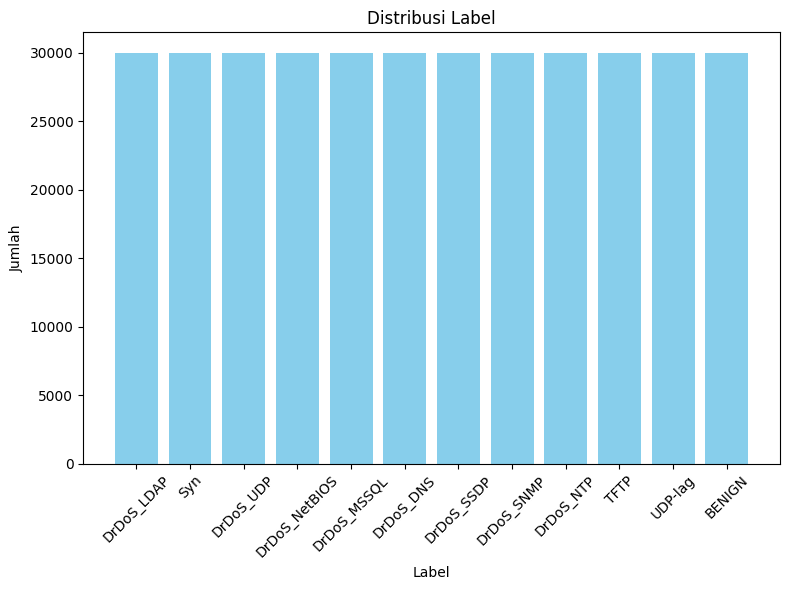

In [8]:
# Hitung jumlah masing-masing label
label_counts = df['Label'].value_counts()

# Buat bar chart
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.title('Distribusi Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

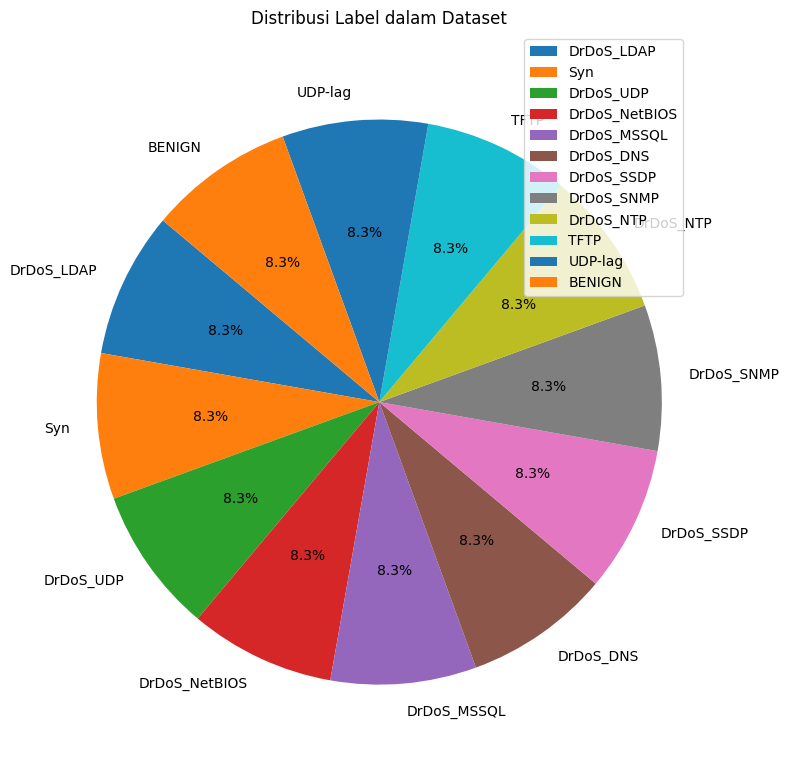

In [9]:
# Hitung jumlah masing-masing label
label_counts = df['Label'].value_counts()

# Buat pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.legend()
plt.title('Distribusi Label dalam Dataset')
plt.axis('equal')  # Agar bentuk pie-nya bulat
plt.tight_layout()
plt.show()

In [10]:
# Menampilkan jumlah sample tiap protocol. '17' = UDP. '6' = TCP. '0' = HOPOPT (IPv6 Hop-by-Hop Option)
df['Protocol'].value_counts()

Protocol
17    285251
6      73805
0        944
Name: count, dtype: int64

### Drop and Encoding Label

In [11]:
df = df.drop(['Flow ID', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Timestamp', 'SimillarHTTP', 'Fwd Header Length.1'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360000 entries, 0 to 359999
Data columns (total 80 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   360000 non-null  int64  
 1   Protocol                     360000 non-null  int64  
 2   Flow Duration                360000 non-null  int64  
 3   Total Fwd Packets            360000 non-null  int64  
 4   Total Backward Packets       360000 non-null  int64  
 5   Total Length of Fwd Packets  360000 non-null  float64
 6   Total Length of Bwd Packets  360000 non-null  float64
 7   Fwd Packet Length Max        360000 non-null  float64
 8   Fwd Packet Length Min        360000 non-null  float64
 9   Fwd Packet Length Mean       360000 non-null  float64
 10  Fwd Packet Length Std        360000 non-null  float64
 11  Bwd Packet Length Max        360000 non-null  float64
 12  Bwd Packet Length Min        360000 non-null  float64
 13 

In [12]:
# Pengubahan nilai dari string (kategorikal) ke numerik
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

label_mapping = pd.DataFrame({
    'Original Label': le.classes_,
    'Encoded Value': range(len(le.classes_))
})

print("Mapping of original labels to encoded values:")
print(label_mapping)

Mapping of original labels to encoded values:
   Original Label  Encoded Value
0          BENIGN              0
1       DrDoS_DNS              1
2      DrDoS_LDAP              2
3     DrDoS_MSSQL              3
4       DrDoS_NTP              4
5   DrDoS_NetBIOS              5
6      DrDoS_SNMP              6
7      DrDoS_SSDP              7
8       DrDoS_UDP              8
9             Syn              9
10           TFTP             10
11        UDP-lag             11


In [13]:
# Menampilkan sampel data setelah encoding (sudah bernilai numerikal)
df.loc[:,['Label']].head()

Label
0      2
1      2
2      9
3      9
4      8

### X dan Y

In [14]:
X = df.drop(['Label'], axis=1)
y = df['Label']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Feature Selection RFE

#### StandarScaler

In [16]:
categorical_features = ['Protocol', 'Inbound']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

In [17]:
# Copy data asli untuk jaga-jaga
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [18]:
# Standarisasi fitur numerik saja
scaler = StandardScaler()

# Standarisasi hanya fitur numerik, simpan hasil ke variabel baru
X_train_scaled = X_train_copy.copy()
X_test_scaled = X_test_copy.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train_copy[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test_copy[numerical_features])

In [19]:
# Opsional: Kalau mau konversi ke array, tinggal pakai
X_train_scaled_array = X_train_scaled.to_numpy()
X_test_scaled_array = X_test_scaled.to_numpy()

In [20]:
X_train.shape

(252000, 79)

#### RFECV

In [31]:
rfecv = RFECV(estimator=RandomForestClassifier(random_state=42), step=1, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
rfecv.fit(X_train_scaled, y_train)

Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 fe

RFECV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
      scoring='accuracy', verbose=1)

In [32]:
ranking = rfecv.ranking_
sorted_idx = np.argsort(ranking)

In [37]:
jumlah_fitur = range(10,70,5)
akurasi = []

for n in jumlah_fitur:
    selected_idx = sorted_idx[:n]
    X_selected = X_train_scaled.iloc[:, selected_idx]  # atau df.iloc[:, selected_idx]
    
    score = cross_val_score(RandomForestClassifier(), X_selected, y_train, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
    mean_score = score.mean()
    akurasi.append(mean_score)

    print(f"{n} fitur → Akurasi: {mean_score:.4f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   36.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


10 fitur → Akurasi: 0.7500


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   34.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


15 fitur → Akurasi: 0.7500


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   33.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


20 fitur → Akurasi: 0.7606


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   38.1s finished


25 fitur → Akurasi: 0.7603


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   38.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


30 fitur → Akurasi: 0.7602


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   35.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


35 fitur → Akurasi: 0.7597


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   37.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


40 fitur → Akurasi: 0.7600


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   37.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


45 fitur → Akurasi: 0.7598


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   38.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


50 fitur → Akurasi: 0.7596


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   37.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


55 fitur → Akurasi: 0.7597


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   37.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


60 fitur → Akurasi: 0.7597
65 fitur → Akurasi: 0.7597


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   38.7s finished


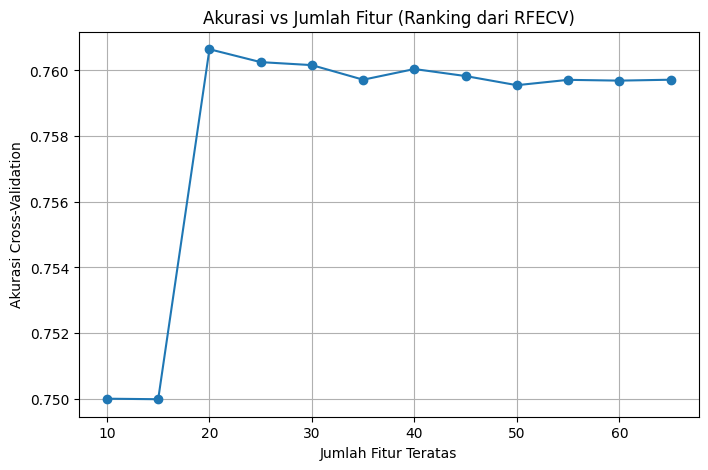

In [38]:
plt.figure(figsize=(8,5))
plt.plot(jumlah_fitur, akurasi, marker='o')
plt.xlabel('Jumlah Fitur Teratas')
plt.ylabel('Akurasi Cross-Validation')
plt.title('Akurasi vs Jumlah Fitur (Ranking dari RFECV)')
plt.grid(True)
plt.show()

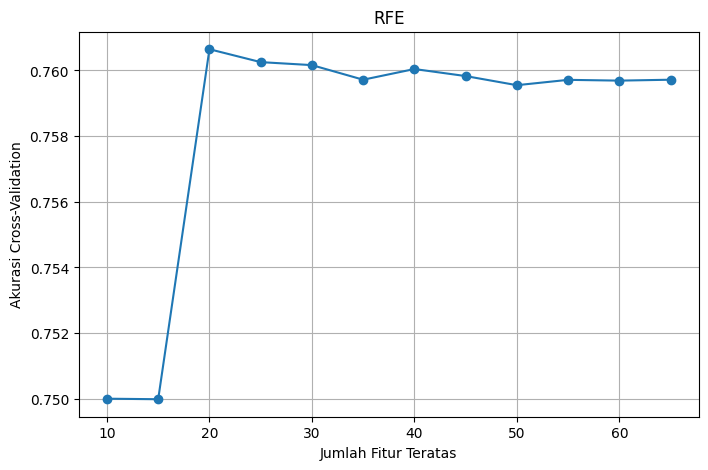

In [39]:
plt.figure(figsize=(8,5))
plt.plot(jumlah_fitur, akurasi, marker='o')
plt.xlabel('Jumlah Fitur Teratas')
plt.ylabel('Akurasi Cross-Validation')
plt.title('RFE')
plt.grid(True)
plt.show()

#### RFE + Random Forest

In [ ]:
# Range jumlah fitur yang diuji
model_rfe = RandomForestClassifier(random_state=42)
k_values = range(10,70,5)
scores_rfe = []

for k in k_values:
    # Buat pipeline RFE + model
    pipeline = Pipeline([
        ('rfe', RFE(estimator= model_rfe, n_features_to_select=k)),
        ('clf', model_rfe)
    ])
    
    # Validasi silang aman (RFE fit hanya di data train tiap fold)
    results = cross_validate(pipeline, X_train_scaled, y_train, cv=3, scoring='accuracy', return_train_score=True, verbose=3)

    mean_test_score = results['test_score'].mean()
    scores_rfe.append(mean_test_score)

# Plot hasil
plt.plot(k_values, scores_rfe, marker='o')
plt.xlabel("Number of Features")
plt.ylabel("Mean CV Accuracy")
plt.title("RFE Feature Selection Performance (via Pipeline)")
plt.grid(True)
plt.show()

#### Selected Features with RFE

In [21]:
# Mendefinisikan model machine learning (Random Forest)
model = RandomForestClassifier()

# Menentukan jumlah fitur yang ingin dipertahankan
num_features_to_retain = 20

# Menginisialisasi selektor RFE dengan model dan jumlah fitur yang ingin dipertahankan
rfe = RFE(estimator=model, n_features_to_select=num_features_to_retain)

# Melatih selektor RFE dengan dataset
rfe.fit(X_train_scaled, y_train)

# Mendapatkan fitur-fitur yang telah terseleksi
selected_features = np.where(rfe.support_)[0]

# Menampilkan indeks fitur terpilih
print("Selected feature indices:", selected_features)

Selected feature indices: [ 0  2  5  7  8  9 15 19 21 22 24 35 39 40 41 48 53 54 63 78]


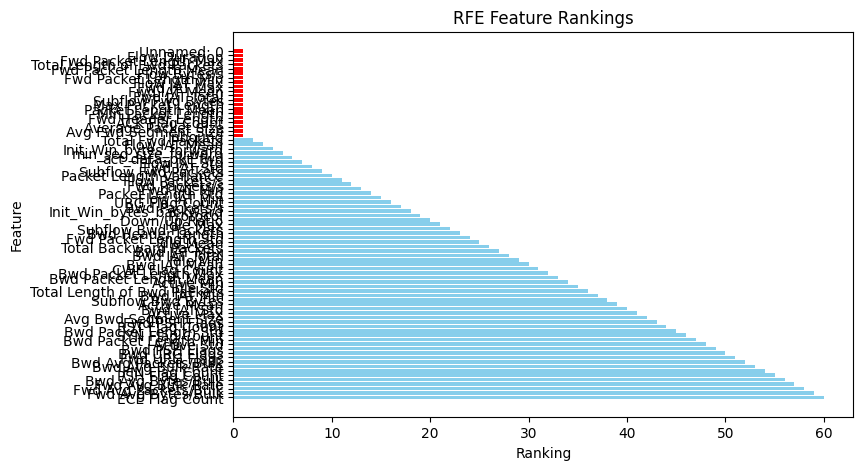

In [22]:
rankings = rfe.ranking_
feature_names = X_train_scaled.columns

# Membuat dataframe untuk visualisasi ranking fitur yang dibuat RFE
ranking_df = pd.DataFrame({
    'Feature': feature_names,
    'Ranking': rankings
}).sort_values(by='Ranking', ascending=True)

# Menampilkan plot visualisasi ranking fitur
plt.figure(figsize=(8, 5))
plt.barh(ranking_df['Feature'], ranking_df['Ranking'], color='skyblue')
plt.xlabel('Ranking')
plt.ylabel('Feature')
plt.title('RFE Feature Rankings')
plt.gca().invert_yaxis()  # Invert y-axis untuk pembacaan yang lebih baik
colors = ['red' if rank == 1 else 'skyblue' for rank in ranking_df['Ranking']]
plt.barh(ranking_df['Feature'], ranking_df['Ranking'], color=colors)
plt.show()

In [21]:
selected_features = [ 0, 2, 5, 7, 8, 9, 15, 19, 21, 22, 24, 35, 39, 40, 41, 48, 53, 54, 63, 78]

In [22]:
# Menyimpan data yang telah terseleksi
X_train_selected_scaled = X_train_scaled.iloc[:, selected_features].to_numpy()
X_test_selected_scaled = X_test_scaled.iloc[:, selected_features].to_numpy()

In [23]:
list = X_train_scaled.columns[selected_features]
print(list)

Index(['Unnamed: 0', 'Flow Duration', 'Total Length of Fwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Flow Bytes/s', 'Flow IAT Max',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd Header Length',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'ACK Flag Count', 'Average Packet Size', 'Avg Fwd Segment Size',
       'Subflow Fwd Bytes', 'Inbound'],
      dtype='object')


In [30]:
X_test_scaled_array

array([[-0.24282183, 17.        , -0.1717637 , ..., -0.15651604,
        -0.14024739,  1.        ],
       [ 0.24146577, 17.        , -0.1717637 , ..., -0.15651604,
        -0.14024739,  1.        ],
       [-0.63685356,  6.        ,  8.90699269, ...,  1.81049224,
         2.28596109,  0.        ],
       ...,
       [-0.45591514, 17.        , -0.1717637 , ..., -0.15651604,
        -0.14024739,  1.        ],
       [-0.25304725, 17.        , -0.15506345, ..., -0.15651604,
        -0.14024739,  1.        ],
       [-0.39273824, 17.        , -0.16336023, ..., -0.15651604,
        -0.14024739,  1.        ]])

In [28]:
X_test_selected_scaled

array([[-0.24282183, -0.1717637 , -0.07773201, ..., -0.34919236,
        -0.07773201,  1.        ],
       [ 0.24146577, -0.1717637 , -0.07773201, ..., -0.34919236,
        -0.07773201,  1.        ],
       [-0.63685356,  8.90699269, -0.07436492, ..., -1.0070599 ,
        -0.07436492,  0.        ],
       ...,
       [-0.45591514, -0.1717637 , -0.02132031, ...,  1.67403352,
        -0.02132031,  1.        ],
       [-0.25304725, -0.15506345, -0.0434913 , ..., -0.41421799,
        -0.0434913 ,  1.        ],
       [-0.39273824, -0.16336023, -0.06136278, ..., -0.41143117,
        -0.06136278,  1.        ]])

### Modeling with Feature Selection

In [ ]:
def evaluate_model(model, X_test, y_test, name="Model"):
    # Waktu prediksi
    start_pred = time.time()
    y_pred = model.predict(X_test)
    end_pred = time.time()
    prediction_time = end_pred - start_pred
    print(f"Waktu prediksi ({name}): {prediction_time:.4f} detik")

    # Hitung metrik evaluasi
    acc = accuracy_score(y_test, y_pred.round())
    prec = precision_score(y_test, y_pred.round(), average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred.round(), average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred.round(), average='macro', zero_division=0)

    print(f"accuracy: {acc}")
    print(f"precision: {prec}")
    print(f"recall: {rec}")
    print(f"f1-score: {f1}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

In [25]:
models = {
    "KNN": KNeighborsClassifier(metric= 'minkowski', n_neighbors= 9, p= 1, weights= 'uniform'),
    "Naive Bayes": GaussianNB(var_smoothing=np.float64(0.01)),
    "Logistic Regression": LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000),
    "Decision Tree": DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42),
    "SVM": SVC(kernel='rbf', C=1, gamma='scale', random_state=42),
    "XGBoost": xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42),
    "Random Forest": RandomForestClassifier(max_depth= 20, max_features= 'sqrt', min_samples_leaf= 4, n_estimators= 300, random_state=42),
    "AdaBoost": AdaBoostClassifier(learning_rate= 0.5, n_estimators= 300, random_state=42)
}

#### Ensemble Learning based on Paper

##### Stacking SVM + NB + DT + RF -> LR

Waktu pelatihan (Stacking base-learner(SVM + RF + DT + NB) + meta-learner(LR)): 1598.9804 detik
Waktu prediksi (Stacking base-learner(SVM + RF + DT + NB) + meta-learner(LR)): 902.4610 detik
accuracy: 0.7927407407407407
precision: 0.8012114583881954
recall: 0.7927407407407406
f1-score: 0.7892868831086647


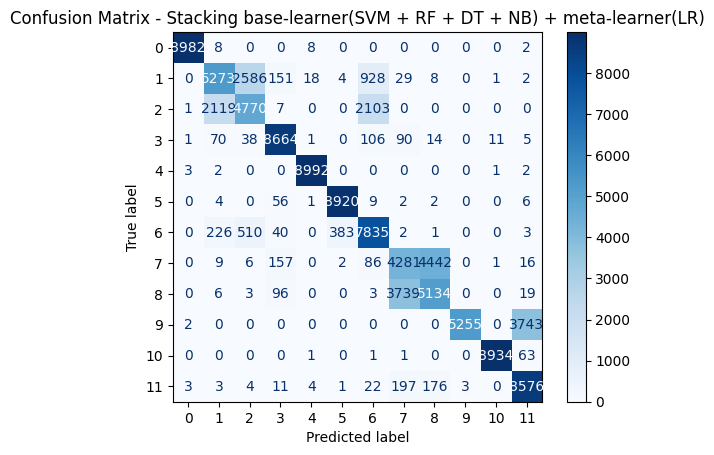

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.59      0.63      9000
           2       0.60      0.53      0.56      9000
           3       0.94      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.71      0.87      0.78      9000
           7       0.51      0.48      0.49      9000
           8       0.53      0.57      0.55      9000
           9       1.00      0.58      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [34]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("SVM", SVC(kernel='rbf', C=1, gamma='scale', random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42)),
    ("Naive Bayes", GaussianNB(var_smoothing=np.float64(0.01)))
]

# Definisikan meta learner
meta_learner =  LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(SVM + RF + DT + NB) + meta-learner(LR)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(SVM + RF + DT + NB) + meta-learner(LR)")

Waktu pelatihan (Stacking base-learner(SVM + RF + DT + NB) + meta-learner(LR)): 1404.4539 detik
Waktu prediksi (Stacking base-learner(SVM + RF + DT + NB) + meta-learner(LR)): 972.3800 detik
accuracy: 0.7862592592592592
precision: 0.8022101873127645
recall: 0.7862592592592593
f1-score: 0.7804888756613524


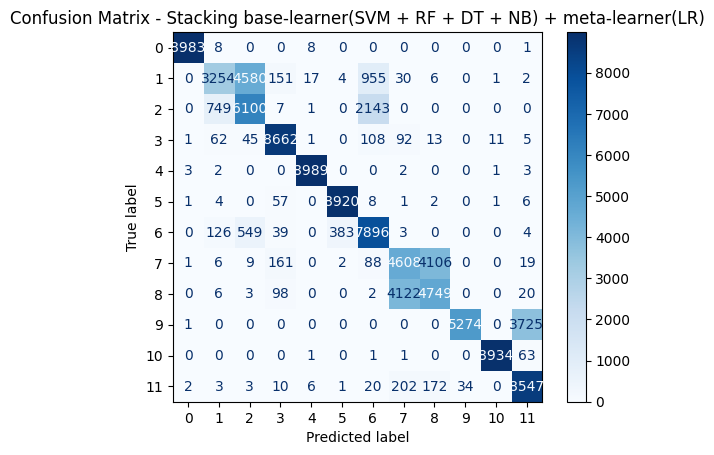

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.77      0.36      0.49      9000
           2       0.54      0.68      0.60      9000
           3       0.94      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.51      0.51      0.51      9000
           8       0.52      0.53      0.53      9000
           9       0.99      0.59      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.78    108000
weighted avg       0.80      0.79      0.78    108000



In [24]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("SVM", SVC(kernel='rbf', C=1, gamma='scale', random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42)),
    ("Naive Bayes", GaussianNB(var_smoothing=np.float64(0.01)))
]

# Definisikan meta learner
meta_learner =  LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=False,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(SVM + RF + DT + NB) + meta-learner(LR)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(SVM + RF + DT + NB) + meta-learner(LR)")

##### LR, SVM, RF, KNN, DT, XGBoost	-> XGBoost (based on Paper 1)

Waktu pelatihan (Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(XGB)): 2075.8619 detik
Waktu prediksi (Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(XGB)): 986.6262 detik
accuracy: 0.7922777777777777
precision: 0.7972663696114948
recall: 0.7922777777777777
f1-score: 0.7891278800666438


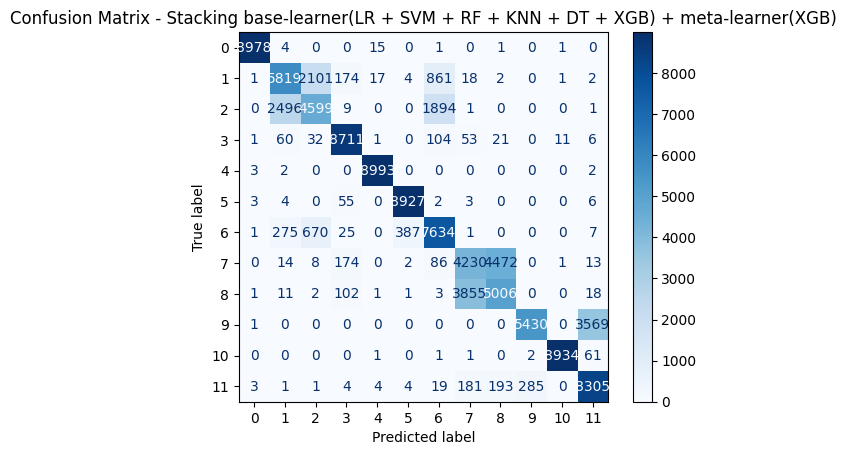

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.67      0.65      0.66      9000
           2       0.62      0.51      0.56      9000
           3       0.94      0.97      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.72      0.85      0.78      9000
           7       0.51      0.47      0.49      9000
           8       0.52      0.56      0.54      9000
           9       0.95      0.60      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.92      0.79      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [26]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("LR", LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)),
    ("SVM", SVC(kernel='rbf', C=1, gamma='scale', random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("KNN", KNeighborsClassifier(metric= 'minkowski', n_neighbors= 9, p= 1, weights= 'uniform')),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42)),
    ("XGBoost", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42))
]

# Definisikan meta learner
meta_learner =  xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(XGB)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(XGB)")

Waktu pelatihan (Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(XGB)): 1551.3141 detik
Waktu prediksi (Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(XGB)): 1083.2908 detik
accuracy: 0.7886851851851852
precision: 0.7905788556905432
recall: 0.7886851851851852
f1-score: 0.7866889090742148


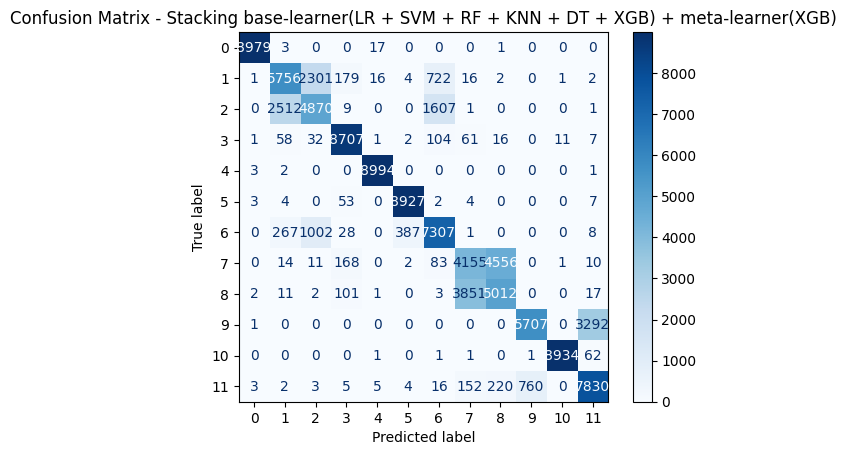

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.67      0.64      0.65      9000
           2       0.59      0.54      0.57      9000
           3       0.94      0.97      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.74      0.81      0.78      9000
           7       0.50      0.46      0.48      9000
           8       0.51      0.56      0.53      9000
           9       0.88      0.63      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.70      0.87      0.77      9000

    accuracy                           0.79    108000
   macro avg       0.79      0.79      0.79    108000
weighted avg       0.79      0.79      0.79    108000



In [27]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("LR", LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)),
    ("SVM", SVC(kernel='rbf', C=1, gamma='scale', random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("KNN", KNeighborsClassifier(metric= 'minkowski', n_neighbors= 9, p= 1, weights= 'uniform')),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42)),
    ("XGBoost", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42))
]

# Definisikan meta learner
meta_learner =  xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=False,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(XGB)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(XGB)")

##### LR, SVM, RF, KNN, DT, XGBoost	-> LR (based on Paper 1)

Waktu pelatihan (Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(LR)): 2150.3888 detik
Waktu prediksi (Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(LR)): 1110.2417 detik
accuracy: 0.7953425925925925
precision: 0.8035387003815657
recall: 0.7953425925925925
f1-score: 0.7924956887498881


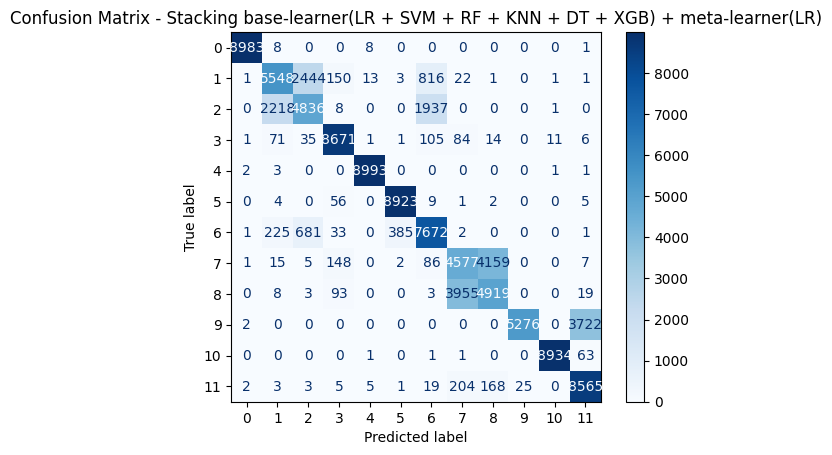

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.62      0.65      9000
           2       0.60      0.54      0.57      9000
           3       0.95      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.72      0.85      0.78      9000
           7       0.52      0.51      0.51      9000
           8       0.53      0.55      0.54      9000
           9       1.00      0.59      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.80    108000
   macro avg       0.80      0.80      0.79    108000
weighted avg       0.80      0.80      0.79    108000



In [28]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("LR", LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)),
    ("SVM", SVC(kernel='rbf', C=1, gamma='scale', random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("KNN", KNeighborsClassifier(metric= 'minkowski', n_neighbors= 9, p= 1, weights= 'uniform')),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42)),
    ("XGBoost", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42))
]

# Definisikan meta learner
meta_learner = LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(LR)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(LR)")

Waktu pelatihan (Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(LR)): 1548.5061 detik
Waktu prediksi (Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(LR)): 1301.1443 detik
accuracy: 0.7933611111111111
precision: 0.8028657353810608
recall: 0.7933611111111113
f1-score: 0.7906949889903179


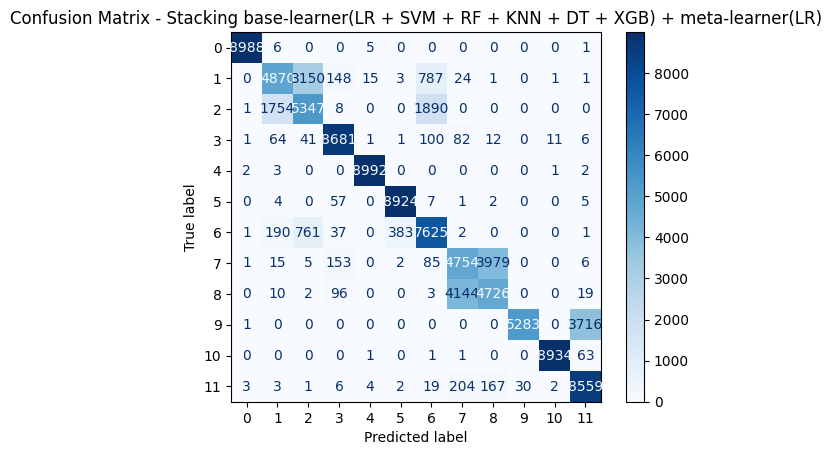

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.70      0.54      0.61      9000
           2       0.57      0.59      0.58      9000
           3       0.95      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.73      0.85      0.78      9000
           7       0.52      0.53      0.52      9000
           8       0.53      0.53      0.53      9000
           9       0.99      0.59      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [29]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("LR", LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)),
    ("SVM", SVC(kernel='rbf', C=1, gamma='scale', random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("KNN", KNeighborsClassifier(metric= 'minkowski', n_neighbors= 9, p= 1, weights= 'uniform')),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42)),
    ("XGBoost", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42))
]

# Definisikan meta learner
meta_learner = LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=False,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(LR)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(LR + SVM + RF + KNN + DT + XGB) + meta-learner(LR)")

##### DT + RF + LR + MLP + kNN based on Paper 3

Waktu pelatihan (Stacking base-learnerDT + RF + LR + MLP + kNN) + meta-learner(RF)): 854.3018 detik
Waktu prediksi (Stacking base-learner(DT + RF + LR + MLP + kNN) + meta-learner(RF)): 23.3561 detik
accuracy: 0.7949722222222222
precision: 0.8031232563583558
recall: 0.7949722222222221
f1-score: 0.7911483782063304


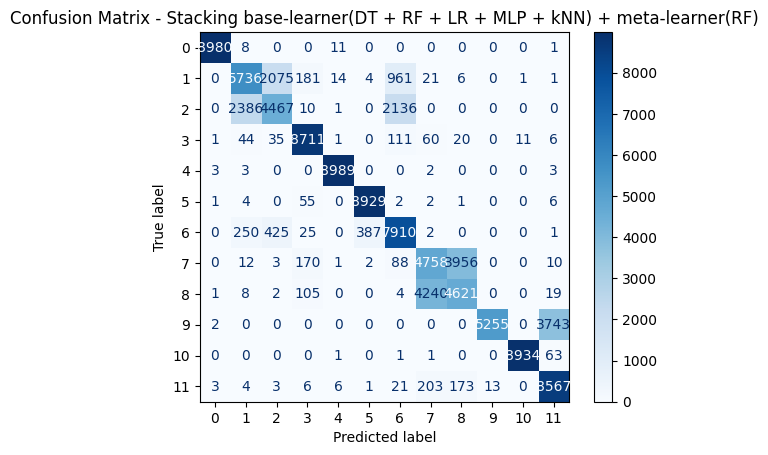

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.64      0.66      9000
           2       0.64      0.50      0.56      9000
           3       0.94      0.97      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.51      0.53      0.52      9000
           8       0.53      0.51      0.52      9000
           9       1.00      0.58      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [37]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("LR", LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)),
    ("KNN", KNeighborsClassifier(n_neighbors=33))
]

# Definisikan meta learner
meta_learner =  RandomForestClassifier(max_depth= 20, max_features= 'sqrt', min_samples_leaf= 4, n_estimators= 300, random_state=42)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learnerDT + RF + LR + MLP + kNN) + meta-learner(RF)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(DT + RF + LR + MLP + kNN) + meta-learner(RF)")

Waktu pelatihan (Stacking base-learnerDT + RF + LR + MLP + kNN) + meta-learner(RF)): 832.6955 detik
Waktu prediksi (Stacking base-learner(DT + RF + LR + MLP + kNN) + meta-learner(RF)): 22.9847 detik
accuracy: 0.7946574074074074
precision: 0.8029298108785413
recall: 0.7946574074074074
f1-score: 0.7906572612525565


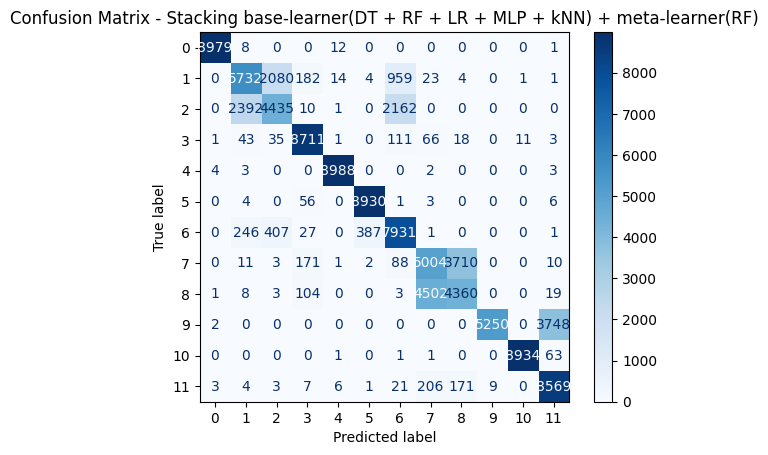

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.64      0.66      9000
           2       0.64      0.49      0.56      9000
           3       0.94      0.97      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.51      0.56      0.53      9000
           8       0.53      0.48      0.51      9000
           9       1.00      0.58      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [36]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("LR", LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)),
    ("KNN", KNeighborsClassifier(n_neighbors=33))
]

# Definisikan meta learner
meta_learner =  RandomForestClassifier(max_depth= 20, max_features= 'sqrt', min_samples_leaf= 4, n_estimators= 300, random_state=42)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=False,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learnerDT + RF + LR + MLP + kNN) + meta-learner(RF)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(DT + RF + LR + MLP + kNN) + meta-learner(RF)")

##### RF + XGB + Extraa Tree Classifier (based on paper 2)

Waktu pelatihan (Stacking base-learner (RF + XGB) + meta-learner(LR)): 367.9107 detik
Waktu prediksi (Stacking base-learner(RF + XGB) + meta-learner(LR)): 4.8155 detik
accuracy: 0.794962962962963
precision: 0.8012222582270736
recall: 0.794962962962963
f1-score: 0.7921549046320302


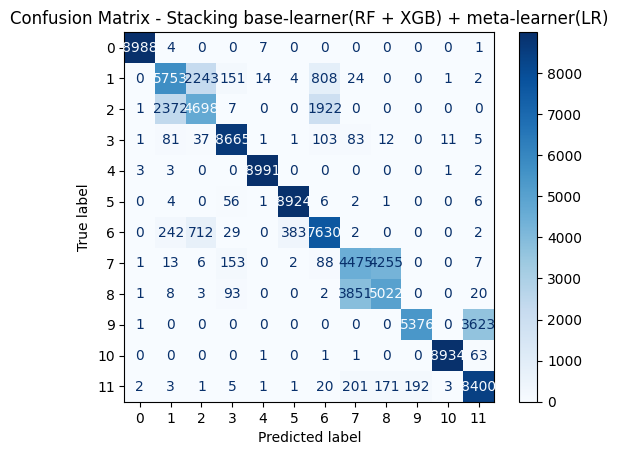

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.64      0.66      9000
           2       0.61      0.52      0.56      9000
           3       0.95      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.72      0.85      0.78      9000
           7       0.52      0.50      0.51      9000
           8       0.53      0.56      0.54      9000
           9       0.97      0.60      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.93      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [38]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("XGB", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42))
]

# Definisikan meta learner
meta_learner = LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner (RF + XGB) + meta-learner(LR)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(RF + XGB) + meta-learner(LR)")

Waktu pelatihan (Stacking base-learner (RF + XGB) + meta-learner(LR)): 231.5513 detik
Waktu prediksi (Stacking base-learner(RF + XGB) + meta-learner(LR)): 4.1976 detik
accuracy: 0.7956666666666666
precision: 0.8018391350108264
recall: 0.7956666666666665
f1-score: 0.7921737493700416


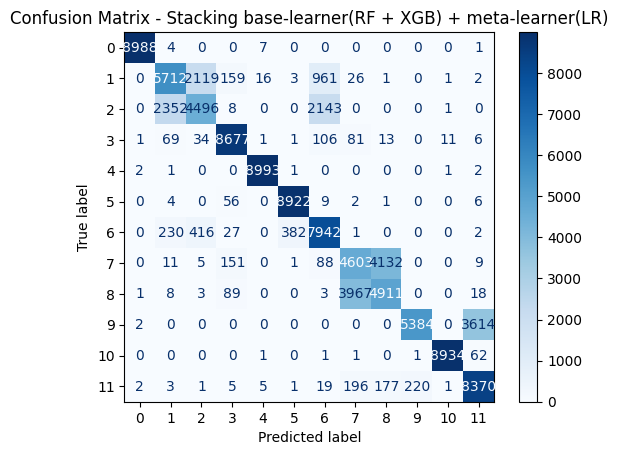

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.63      0.66      9000
           2       0.64      0.50      0.56      9000
           3       0.95      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.52      0.51      0.51      9000
           8       0.53      0.55      0.54      9000
           9       0.96      0.60      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.93      0.79      9000

    accuracy                           0.80    108000
   macro avg       0.80      0.80      0.79    108000
weighted avg       0.80      0.80      0.79    108000



In [39]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("XGB", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42))
]

# Definisikan meta learner
meta_learner = LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=False,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner (RF + XGB) + meta-learner(LR)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(RF + XGB) + meta-learner(LR)")

##### DT + RF + XGB 

Waktu pelatihan (Stacking base-learner(DT + RF + XGB) + meta-learner(XGB)): 217.7349 detik
Waktu prediksi (Stacking base-learner(DT + RF + XGB) + meta-learner(XGB)): 5.4036 detik
accuracy: 0.7928333333333333
precision: 0.7998840898356683
recall: 0.7928333333333334
f1-score: 0.7885488326521269


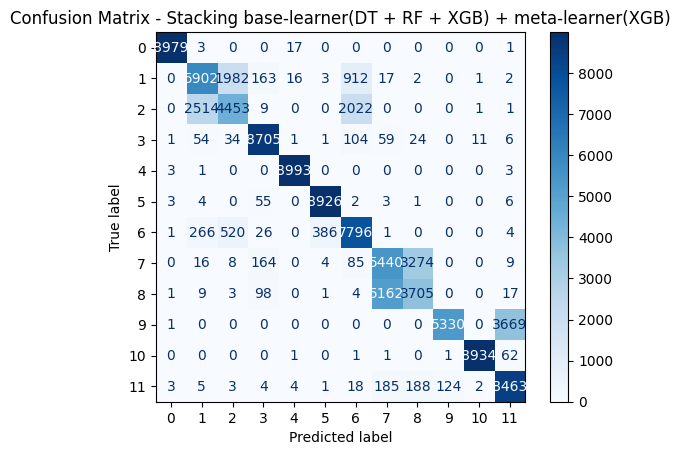

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.67      0.66      0.66      9000
           2       0.64      0.49      0.56      9000
           3       0.94      0.97      0.96      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.71      0.87      0.78      9000
           7       0.50      0.60      0.55      9000
           8       0.52      0.41      0.46      9000
           9       0.98      0.59      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.94      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [34]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("XGB", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42)),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42))
]

# Definisikan meta learner
meta_learner =  xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=False,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(DT + RF + XGB) + meta-learner(XGB)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(DT + RF + XGB) + meta-learner(XGB)")

Waktu pelatihan (Stacking base-learner(DT + RF + XGB) + meta-learner(XGB)): 201.5578 detik
Waktu prediksi (Stacking base-learner(DT + RF + XGB) + meta-learner(XGB)): 4.4005 detik
accuracy: 0.7920833333333334
precision: 0.7978882165225096
recall: 0.7920833333333334
f1-score: 0.7886272989161355


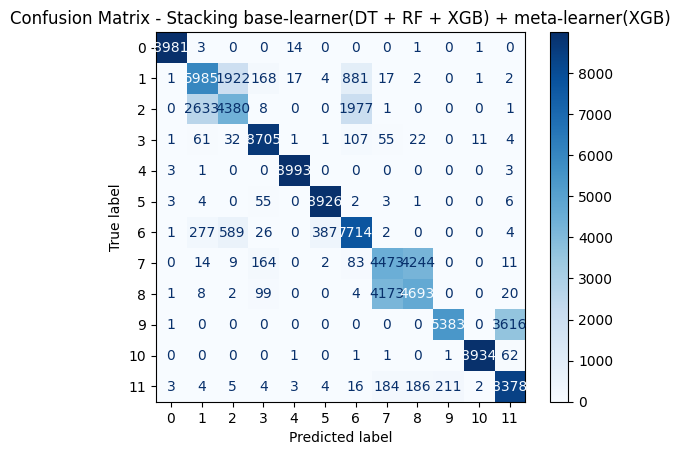

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.67      0.67      0.67      9000
           2       0.63      0.49      0.55      9000
           3       0.94      0.97      0.96      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.72      0.86      0.78      9000
           7       0.50      0.50      0.50      9000
           8       0.51      0.52      0.52      9000
           9       0.96      0.60      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.93      0.79      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [35]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("XGB", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42)),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42))
]

# Definisikan meta learner
meta_learner =  xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(DT + RF + XGB) + meta-learner(XGB)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(DT + RF + XGB) + meta-learner(XGB)")

#### Ensemble Learning

##### Stacking SVM + NB + kNN + LR + XGB -> RF

Waktu pelatihan (Stacking base-learner(SVM + NB + KNN + LR) + meta-learner(RF)): 1797.0472 detik
Waktu prediksi (Stacking base-learner(SVM + NB + KNN + LR) + meta-learner(RF)): 946.8037 detik
accuracy: 0.7892037037037037
precision: 0.7944655038486227
recall: 0.7892037037037039
f1-score: 0.784563170281432


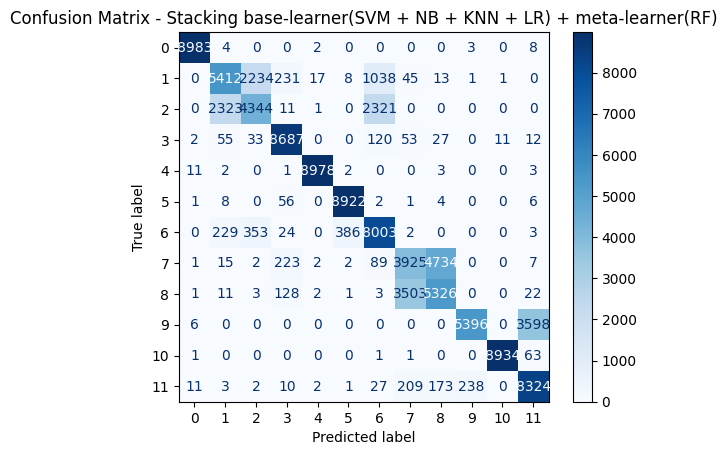

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.67      0.60      0.63      9000
           2       0.62      0.48      0.54      9000
           3       0.93      0.97      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.69      0.89      0.78      9000
           7       0.51      0.44      0.47      9000
           8       0.52      0.59      0.55      9000
           9       0.96      0.60      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.92      0.79      9000

    accuracy                           0.79    108000
   macro avg       0.79      0.79      0.78    108000
weighted avg       0.79      0.79      0.78    108000



In [32]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("SVM", SVC(kernel='rbf', C=1, gamma='scale', random_state=42)),
    ("Naive Bayes", GaussianNB(var_smoothing=np.float64(0.01))),
    ("KNN", KNeighborsClassifier(n_neighbors=33)),
    ("LR", LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000))
    
]

# Definisikan meta learner
meta_learner =  RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(SVM + NB + KNN + LR) + meta-learner(RF)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(SVM + NB + KNN + LR) + meta-learner(RF)")

Waktu pelatihan (Stacking base-learner(SVM + NB + KNN + LR) + meta-learner(RF)): 1738.1499 detik
Waktu prediksi (Stacking base-learner(SVM + NB + KNN + LR) + meta-learner(RF)): 935.7927 detik
accuracy: 0.7456203703703703
precision: 0.7603040937368788
recall: 0.7456203703703704
f1-score: 0.7388788307591995


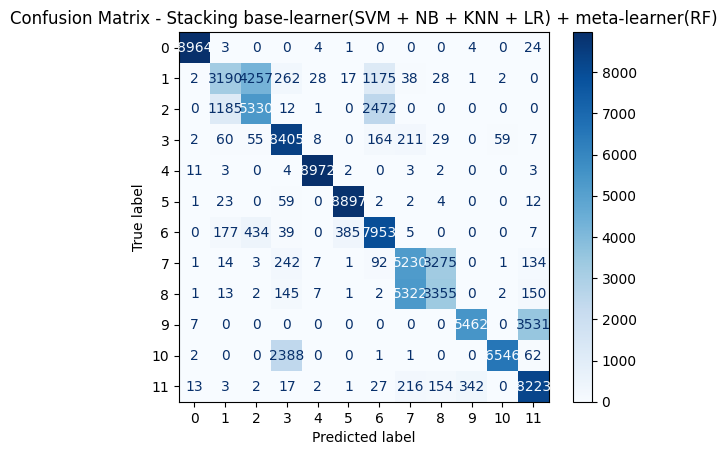

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.35      0.47      9000
           2       0.53      0.59      0.56      9000
           3       0.73      0.93      0.82      9000
           4       0.99      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.67      0.88      0.76      9000
           7       0.47      0.58      0.52      9000
           8       0.49      0.37      0.42      9000
           9       0.94      0.61      0.74      9000
          10       0.99      0.73      0.84      9000
          11       0.68      0.91      0.78      9000

    accuracy                           0.75    108000
   macro avg       0.76      0.75      0.74    108000
weighted avg       0.76      0.75      0.74    108000



In [31]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("SVM", SVC(kernel='rbf', C=1, gamma='scale', random_state=42)),
    ("Naive Bayes", GaussianNB(var_smoothing=np.float64(0.01))),
    ("KNN", KNeighborsClassifier(n_neighbors=33)),
    ("LR", LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000))    
]

# Definisikan meta learner
meta_learner =  RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=False,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(SVM + NB + KNN + LR) + meta-learner(RF)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(SVM + NB + KNN + LR) + meta-learner(RF)")

##### Stacking RF + AB + XGB + DT -> RF

Waktu pelatihan (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (RF)): 496.9951 detik
Waktu prediksi (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (RF)): 11.2703 detik
accuracy: 0.7947685185185185
precision: 0.80608472506494
recall: 0.7947685185185186
f1-score: 0.7835162946045099


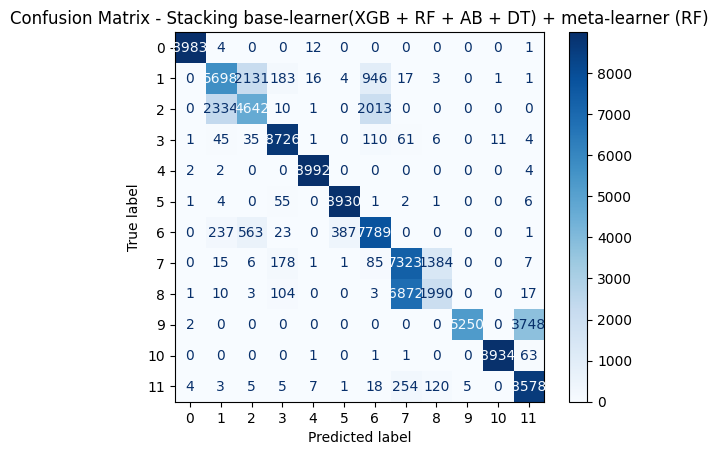

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.63      0.66      9000
           2       0.63      0.52      0.57      9000
           3       0.94      0.97      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.71      0.87      0.78      9000
           7       0.50      0.81      0.62      9000
           8       0.57      0.22      0.32      9000
           9       1.00      0.58      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.81      0.79      0.78    108000
weighted avg       0.81      0.79      0.78    108000



In [27]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("XGB", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("AB", AdaBoostClassifier(learning_rate= 0.5, n_estimators= 300, random_state=42)),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42))
]

# Definisikan meta learner
meta_learner = RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (RF)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(XGB + RF + AB + DT) + meta-learner (RF)")

Waktu pelatihan (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (RF)): 382.5490 detik
Waktu prediksi (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (RF)): 10.8439 detik
accuracy: 0.7942222222222223
precision: 0.8059633692199683
recall: 0.7942222222222224
f1-score: 0.7826975994224012


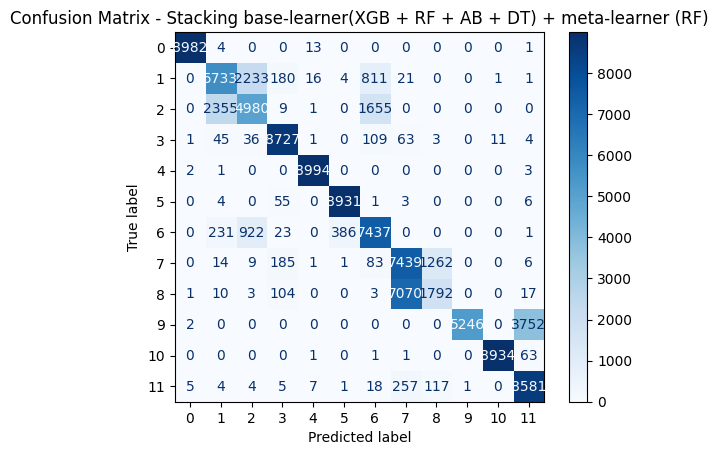

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.64      0.66      9000
           2       0.61      0.55      0.58      9000
           3       0.94      0.97      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.74      0.83      0.78      9000
           7       0.50      0.83      0.62      9000
           8       0.56      0.20      0.29      9000
           9       1.00      0.58      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.81      0.79      0.78    108000
weighted avg       0.81      0.79      0.78    108000



In [28]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("XGB", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("AB", AdaBoostClassifier(learning_rate= 0.5, n_estimators= 300, random_state=42)),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42))
]

# Definisikan meta learner
meta_learner = RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=False,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (RF)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(XGB + RF + AB + DT) + meta-learner (RF)")

##### Stacking RF + AB + XGB + DT -> LR

Waktu pelatihan (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (LR)): 359.4900 detik
Waktu prediksi (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (LR)): 8.8762 detik
accuracy: 0.795675925925926
precision: 0.8039128741692618
recall: 0.795675925925926
f1-score: 0.792740281631468


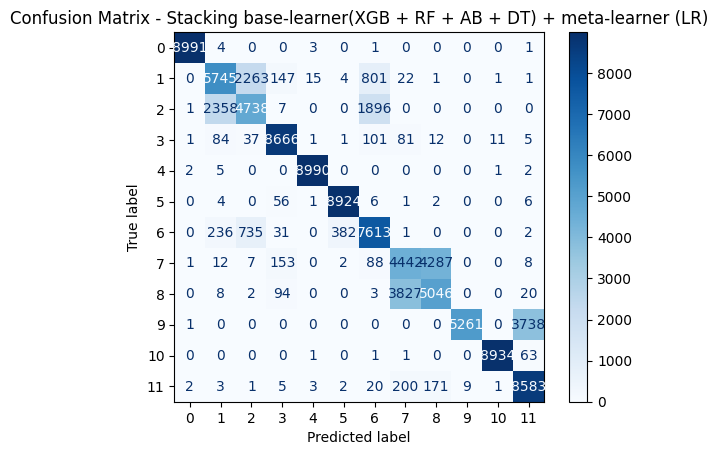

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.64      0.66      9000
           2       0.61      0.53      0.56      9000
           3       0.95      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.72      0.85      0.78      9000
           7       0.52      0.49      0.51      9000
           8       0.53      0.56      0.54      9000
           9       1.00      0.58      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.80    108000
   macro avg       0.80      0.80      0.79    108000
weighted avg       0.80      0.80      0.79    108000



In [25]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("XGB", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("AdaBoost", AdaBoostClassifier(learning_rate= 0.5, n_estimators= 300, random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42))
]

# Definisikan meta learner
meta_learner = LogisticRegression(max_iter=5000, penalty= None, solver= 'newton-cg')

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (LR)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(XGB + RF + AB + DT) + meta-learner (LR)")

Waktu pelatihan (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (LR)): 238.1417 detik
Waktu prediksi (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (LR)): 8.6882 detik
accuracy: 0.7962037037037037
precision: 0.8042808203983692
recall: 0.7962037037037036
f1-score: 0.7925321114215432


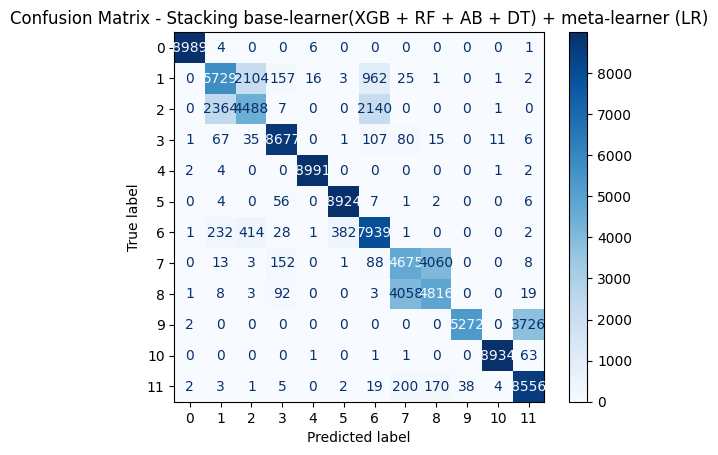

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.64      0.66      9000
           2       0.64      0.50      0.56      9000
           3       0.95      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.52      0.52      0.52      9000
           8       0.53      0.54      0.53      9000
           9       0.99      0.59      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.80    108000
   macro avg       0.80      0.80      0.79    108000
weighted avg       0.80      0.80      0.79    108000



In [26]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("XGB", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("AdaBoost", AdaBoostClassifier(learning_rate= 0.5, n_estimators= 300, random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42))
]

# Definisikan meta learner
meta_learner = LogisticRegression(max_iter=5000, penalty= None, solver= 'newton-cg')

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=False,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking base-learner(XGB + RF + AB + DT) + meta-learner (LR)): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking base-learner(XGB + RF + AB + DT) + meta-learner (LR)")

##### X

Waktu pelatihan (Stacking XGB + LR + KNN + RF + LR): 488.8032 detik
Waktu prediksi (Stacking XGB + LR + KNN + RF + LR): 18.7439 detik
accuracy: 0.7948888888888889
precision: 0.8008824502344112
recall: 0.794888888888889
f1-score: 0.7918628352843591


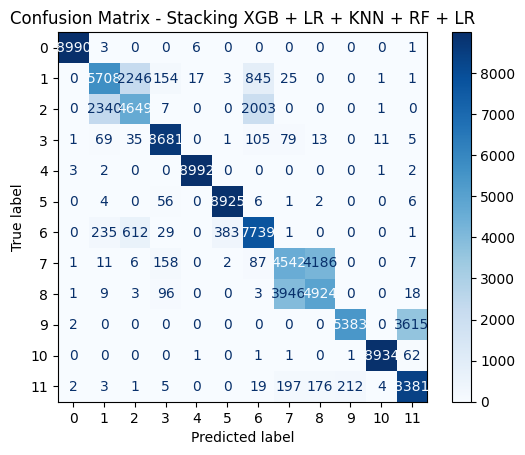

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.63      0.66      9000
           2       0.62      0.52      0.56      9000
           3       0.95      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.72      0.86      0.78      9000
           7       0.52      0.50      0.51      9000
           8       0.53      0.55      0.54      9000
           9       0.96      0.60      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.93      0.79      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [33]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("XGB", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42)),
    ("LR", LogisticRegression(max_iter=5000, penalty= None, solver= 'newton-cg')),
    ("KNN", KNeighborsClassifier(n_neighbors=33)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42))
]

# Definisikan meta learner
meta_learner = LogisticRegression(max_iter=5000, penalty= None, solver= 'newton-cg')

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=False,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking XGB + LR + KNN + RF + LR): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking XGB + LR + KNN + RF + LR")

Waktu pelatihan (Stacking XGB + LR + KNN + RF + LR): 612.3323 detik
Waktu prediksi (Stacking XGB + LR + KNN + RF + LR): 19.3076 detik
accuracy: 0.7946944444444445
precision: 0.8008255983268633
recall: 0.7946944444444445
f1-score: 0.7916701466266374


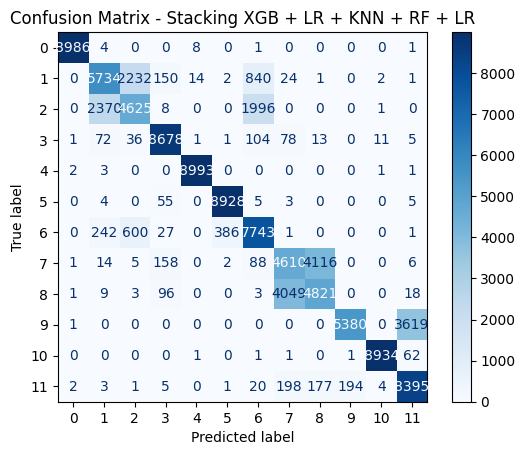

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.64      0.66      9000
           2       0.62      0.51      0.56      9000
           3       0.95      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.72      0.86      0.78      9000
           7       0.51      0.51      0.51      9000
           8       0.53      0.54      0.53      9000
           9       0.97      0.60      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.93      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [32]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("XGB", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42)),
    ("LR", LogisticRegression(max_iter=5000, penalty= None, solver= 'newton-cg')),
    ("KNN", KNeighborsClassifier(n_neighbors=33)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42))
]

# Definisikan meta learner
meta_learner = LogisticRegression(max_iter=5000, penalty= None, solver= 'newton-cg')

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking XGB + LR + KNN + RF + LR): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking XGB + LR + KNN + RF + LR")

##### Stacking XGB + LR + KNN -> RF

Waktu pelatihan (Stacking XGB + LR + KNN + RF): 889.9956 detik
Waktu prediksi (Stacking XGB + LR + KNN + RF): 18.5229 detik
accuracy: 0.7922222222222223
precision: 0.8019825696659741
recall: 0.7922222222222223
f1-score: 0.7813132540372325


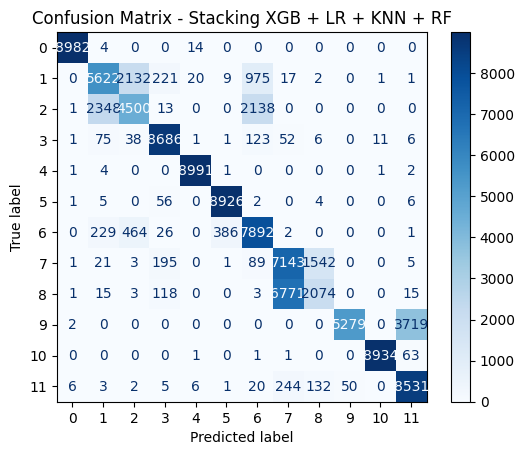

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.62      0.65      9000
           2       0.63      0.50      0.56      9000
           3       0.93      0.97      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.50      0.79      0.61      9000
           8       0.55      0.23      0.33      9000
           9       0.99      0.59      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.78    108000
weighted avg       0.80      0.79      0.78    108000



In [31]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("XGB", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42)),
    ("LR", LogisticRegression(max_iter=5000, penalty= None, solver= 'newton-cg')),
    ("KNN", KNeighborsClassifier(n_neighbors=33))
]

# Definisikan meta learner
meta_learner = RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking XGB + LR + KNN + RF): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking XGB + LR + KNN + RF")

Waktu pelatihan (Stacking XGB + RF + KNN + LR): 335.6978 detik
Waktu prediksi (Stacking XGB + RF + KNN + LR): 21.1585 detik
accuracy: 0.7943425925925925
precision: 0.8007011575305915
recall: 0.7943425925925927
f1-score: 0.791885333625812


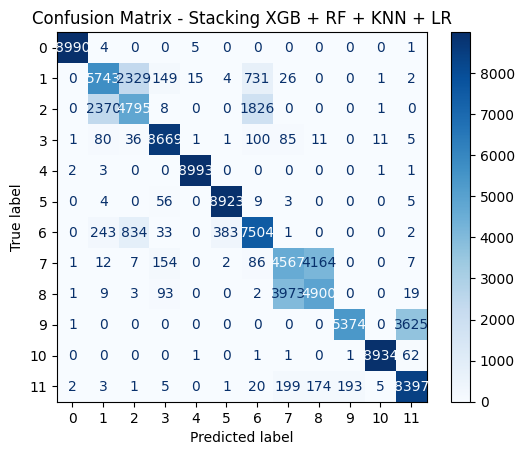

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.64      0.66      9000
           2       0.60      0.53      0.56      9000
           3       0.95      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.73      0.83      0.78      9000
           7       0.52      0.51      0.51      9000
           8       0.53      0.54      0.54      9000
           9       0.97      0.60      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.93      0.79      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [ ]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("XGB", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("KNN", KNeighborsClassifier(n_neighbors=33))
]

# Definisikan meta learner
meta_learner = LogisticRegression(max_iter=5000, penalty= None, solver= 'newton-cg')

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking XGB + RF + KNN + LR): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking XGB + RF + KNN + LR")

Waktu prediksi (Stacking XGB + RF + SVM + LR): 1086.2481 detik
accuracy: 0.7946203703703704
precision: 0.8012488005927118
recall: 0.7946203703703705
f1-score: 0.7916138905424216


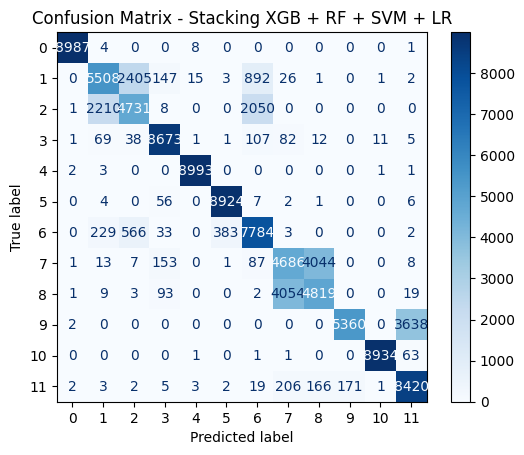

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.61      0.65      9000
           2       0.61      0.53      0.56      9000
           3       0.95      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.71      0.86      0.78      9000
           7       0.52      0.52      0.52      9000
           8       0.53      0.54      0.53      9000
           9       0.97      0.60      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.94      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [ ]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("XGB", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("SVM", SVC(kernel='rbf', C=1, gamma='scale', random_state=42))
]

# Definisikan meta learner
meta_learner = LogisticRegression(max_iter=5000, penalty= None, solver= 'newton-cg')

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking XGB + RF + SVM + LR): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking XGB + RF + SVM + LR")

##### Stacking DT + SVM + LR -> XGB

Waktu pelatihan (Stacking DT + SVM + LR + XGB): 1345.4569 detik
Waktu prediksi (Stacking DT + SVM + LR + XGB): 1018.5334 detik
accuracy: 0.7925648148148148
precision: 0.8001465072757338
recall: 0.7925648148148148
f1-score: 0.7878220597640776


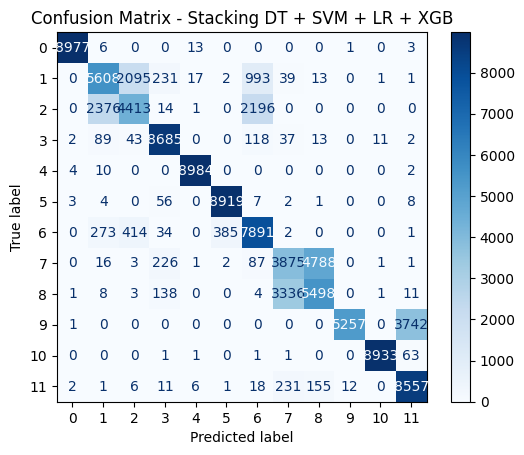

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.67      0.62      0.64      9000
           2       0.63      0.49      0.55      9000
           3       0.92      0.96      0.94      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.52      0.43      0.47      9000
           8       0.53      0.61      0.56      9000
           9       1.00      0.58      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [ ]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2,  random_state=42)), 
    ("SVM", SVC(kernel='rbf', C=1, gamma='scale', random_state=42)),
    ("LR", LogisticRegression(max_iter=5000, penalty= None, solver= 'newton-cg'))
]

# Definisikan meta learner
meta_learner = xgb.XGBClassifier(tree_method="hist", gamma=0.3, learning_rate=0.1, max_depth=5, reg_alpha=0.01, reg_lambda=1, random_state=42)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking DT + SVM + LR + XGB): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking DT + SVM + LR + XGB")


##### Stacking GBC + RF + KNN -> LR

Waktu pelatihan (Stacking GBC + RF + KNN + LR): 1167.1146 detik
Waktu prediksi (Stacking GBC + RF + KNN + LR): 20.4136 detik
accuracy: 0.7953703703703704
precision: 0.8033532640110442
recall: 0.7953703703703704
f1-score: 0.7921853933493948


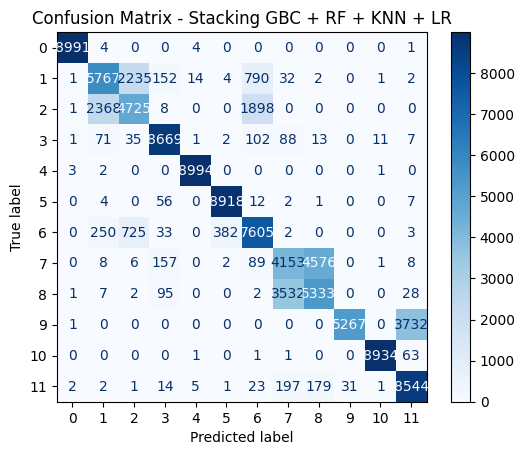

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.64      0.66      9000
           2       0.61      0.53      0.56      9000
           3       0.94      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.72      0.84      0.78      9000
           7       0.52      0.46      0.49      9000
           8       0.53      0.59      0.56      9000
           9       0.99      0.59      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.80    108000
   macro avg       0.80      0.80      0.79    108000
weighted avg       0.80      0.80      0.79    108000



In [ ]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("GBC", GradientBoostingClassifier(random_state=42)),
    ("RF", RandomForestClassifier(max_depth= 20, max_features= 'sqrt', min_samples_leaf= 4, n_estimators= 300, random_state=42)),
    ("KNN", KNeighborsClassifier(n_neighbors=33))
]

# Definisikan meta learner
meta_learner = LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Stacking GBC + RF + KNN + LR): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking GBC + RF + KNN + LR")


##### Stacking XGB + RF + KNN -> LR

Waktu pelatihan ( ): 279.0248 detik
Waktu prediksi (Stacking XGB + RF + KNN + LR): 19.4372 detik
accuracy: 0.7943425925925925
precision: 0.8007011575305915
recall: 0.7943425925925927
f1-score: 0.791885333625812


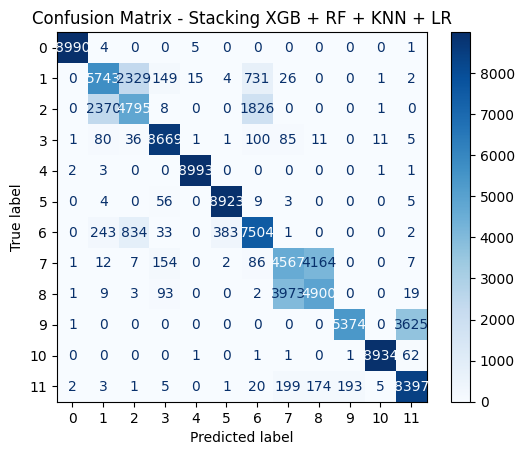

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.64      0.66      9000
           2       0.60      0.53      0.56      9000
           3       0.95      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.73      0.83      0.78      9000
           7       0.52      0.51      0.51      9000
           8       0.53      0.54      0.54      9000
           9       0.97      0.60      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.93      0.79      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [ ]:
# Definisikan base learner (bisa ditambah jika mau)
start_train = time.time()

base_learners = [
    ("XGB", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42)),
    ("RF", RandomForestClassifier(max_depth= 20, max_features= 'sqrt', min_samples_leaf= 4, n_estimators= 300, random_state=42)),
    ("KNN", KNeighborsClassifier(n_neighbors=33))
]

# Definisikan meta learner
meta_learner = LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)

# Definisikan Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True,  # kalau True, input fitur asli juga masuk ke meta-learner
    verbose=3
)

# Latih model stacking
stacking_clf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan ( ): {training_time:.4f} detik")

# Prediksi dan evaluasi
evaluate_model_2(stacking_clf, X_test_selected_scaled, y_test, name="Stacking XGB + RF + KNN + LR")


#### Algoritma Individual

##### LogReg

Waktu pelatihan (Logistic Regression): 305.3962 detik
Waktu prediksi (Logistic Regression): 0.0426 detik


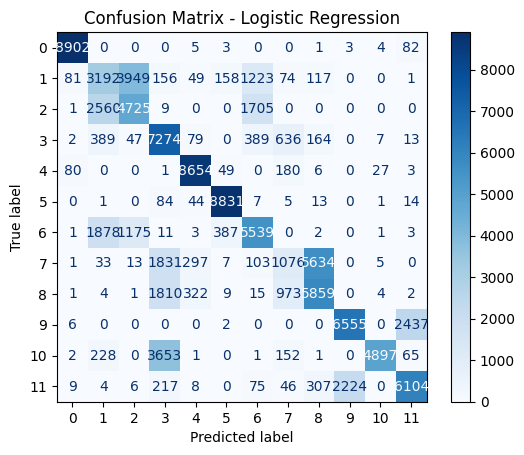

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      9000
           1       0.39      0.35      0.37      9000
           2       0.48      0.53      0.50      9000
           3       0.48      0.81      0.61      9000
           4       0.91      0.96      0.94      9000
           5       0.93      0.98      0.96      9000
           6       0.61      0.62      0.61      9000
           7       0.34      0.12      0.18      9000
           8       0.48      0.65      0.56      9000
           9       0.75      0.73      0.74      9000
          10       0.99      0.54      0.70      9000
          11       0.70      0.68      0.69      9000

    accuracy                           0.66    108000
   macro avg       0.67      0.66      0.65    108000
weighted avg       0.67      0.66      0.65    108000



In [36]:
# Logistic Regression
start_train = time.time()

logreg = LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)
logreg.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Logistic Regression): {training_time:.4f} detik")

evaluate_model(logreg, X_test_selected_scaled, y_test, name="Logistic Regression")

Waktu pelatihan (Logistic Regression): 69.7261 detik
Waktu prediksi (Logistic Regression): 0.0451 detik


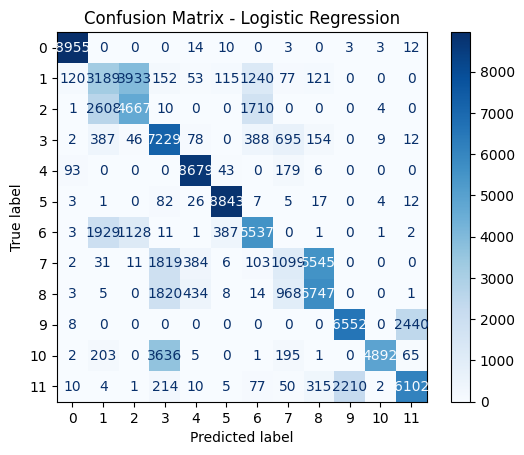

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9000
           1       0.38      0.35      0.37      9000
           2       0.48      0.52      0.50      9000
           3       0.48      0.80      0.60      9000
           4       0.90      0.96      0.93      9000
           5       0.94      0.98      0.96      9000
           6       0.61      0.62      0.61      9000
           7       0.34      0.12      0.18      9000
           8       0.48      0.64      0.55      9000
           9       0.75      0.73      0.74      9000
          10       1.00      0.54      0.70      9000
          11       0.71      0.68      0.69      9000

    accuracy                           0.66    108000
   macro avg       0.67      0.66      0.65    108000
weighted avg       0.67      0.66      0.65    108000



In [63]:
# Logistic Regression
start_train = time.time()

logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Logistic Regression): {training_time:.4f} detik")

evaluate_model(logreg, X_test_selected_scaled, y_test, name="Logistic Regression")

##### Adaboost

Waktu pelatihan (AdaBoost): 58.1437 detik
Waktu prediksi (AdaBoost Classifier): 4.7867 detik


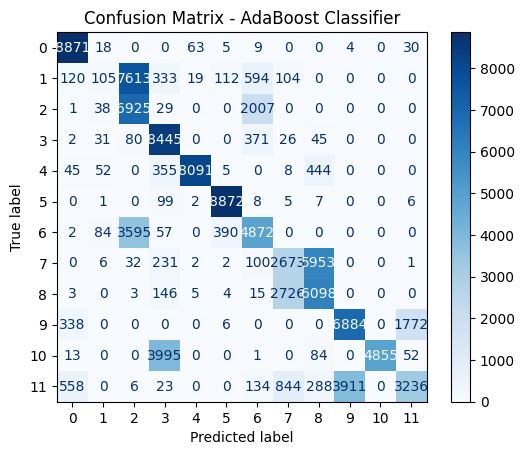

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      9000
           1       0.31      0.01      0.02      9000
           2       0.38      0.77      0.51      9000
           3       0.62      0.94      0.74      9000
           4       0.99      0.90      0.94      9000
           5       0.94      0.99      0.96      9000
           6       0.60      0.54      0.57      9000
           7       0.42      0.30      0.35      9000
           8       0.47      0.68      0.56      9000
           9       0.64      0.76      0.70      9000
          10       1.00      0.54      0.70      9000
          11       0.63      0.36      0.46      9000

    accuracy                           0.65    108000
   macro avg       0.66      0.65      0.62    108000
weighted avg       0.66      0.65      0.62    108000



In [37]:
# AdaBoost
start_train = time.time()

adc = AdaBoostClassifier(learning_rate= 0.5, n_estimators= 300, random_state=42)
adc.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (AdaBoost): {training_time:.4f} detik")

evaluate_model(adc, X_test_selected_scaled, y_test, name="AdaBoost Classifier")

Waktu pelatihan (AdaBoost): 12.3492 detik
Waktu prediksi (AdaBoost Classifier): 0.7930 detik


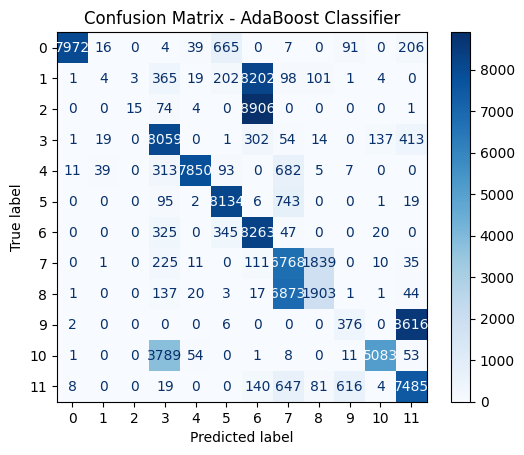

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      9000
           1       0.05      0.00      0.00      9000
           2       0.83      0.00      0.00      9000
           3       0.60      0.90      0.72      9000
           4       0.98      0.87      0.92      9000
           5       0.86      0.90      0.88      9000
           6       0.32      0.92      0.47      9000
           7       0.42      0.75      0.54      9000
           8       0.48      0.21      0.29      9000
           9       0.34      0.04      0.07      9000
          10       0.97      0.56      0.71      9000
          11       0.44      0.83      0.58      9000

    accuracy                           0.57    108000
   macro avg       0.61      0.57      0.51    108000
weighted avg       0.61      0.57      0.51    108000



In [40]:
# AdaBoost
start_train = time.time()

adc = AdaBoostClassifier(random_state=42)
adc.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (AdaBoost): {training_time:.4f} detik")

evaluate_model(adc, X_test_selected_scaled, y_test, name="AdaBoost Classifier")

##### kNN

Waktu pelatihan (KNN): 0.0265 detik
Waktu prediksi (KNN): 36.2252 detik
accuracy: 0.7692407407407408
precision: 0.7698368478228347
recall: 0.7692407407407408
f1-score: 0.767576514415809


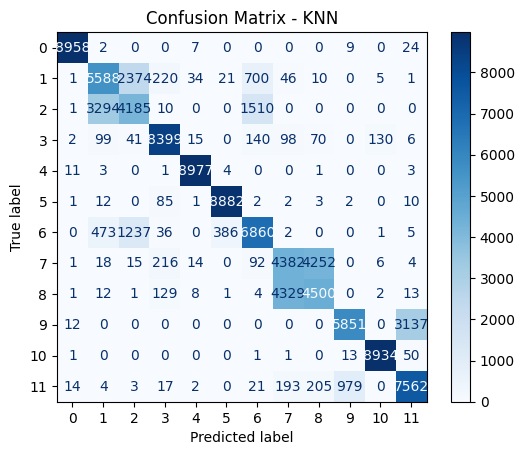

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.59      0.62      0.60      9000
           2       0.53      0.47      0.50      9000
           3       0.92      0.93      0.93      9000
           4       0.99      1.00      0.99      9000
           5       0.96      0.99      0.97      9000
           6       0.74      0.76      0.75      9000
           7       0.48      0.49      0.49      9000
           8       0.50      0.50      0.50      9000
           9       0.85      0.65      0.74      9000
          10       0.98      0.99      0.99      9000
          11       0.70      0.84      0.76      9000

    accuracy                           0.77    108000
   macro avg       0.77      0.77      0.77    108000
weighted avg       0.77      0.77      0.77    108000



In [25]:
# KNN
start_train = time.time()

knn = KNeighborsClassifier(metric= 'minkowski', n_neighbors= 17, p= 1, weights= 'uniform')
knn.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (KNN): {training_time:.4f} detik")

evaluate_model_2(knn, X_test_selected_scaled, y_test, name="KNN")


Waktu pelatihan (KNN): 0.0230 detik
Waktu prediksi (KNN): 36.5525 detik
accuracy: 0.7678333333333334
precision: 0.7677917392803847
recall: 0.7678333333333334
f1-score: 0.766960339147308


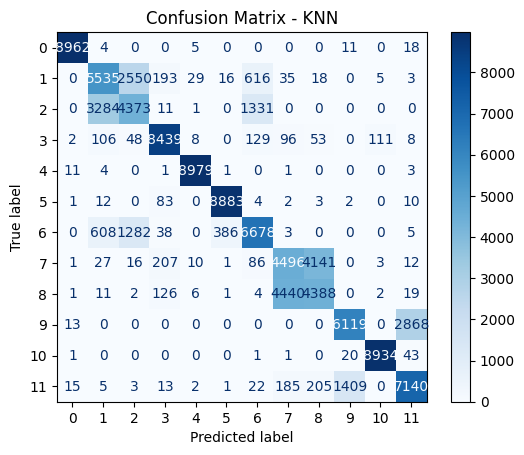

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.58      0.61      0.60      9000
           2       0.53      0.49      0.51      9000
           3       0.93      0.94      0.93      9000
           4       0.99      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.75      0.74      0.75      9000
           7       0.49      0.50      0.49      9000
           8       0.50      0.49      0.49      9000
           9       0.81      0.68      0.74      9000
          10       0.99      0.99      0.99      9000
          11       0.70      0.79      0.75      9000

    accuracy                           0.77    108000
   macro avg       0.77      0.77      0.77    108000
weighted avg       0.77      0.77      0.77    108000



In [26]:
# KNN
start_train = time.time()

knn = KNeighborsClassifier(metric= 'minkowski', n_neighbors= 9, p= 1, weights= 'uniform')
knn.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (KNN): {training_time:.4f} detik")

evaluate_model_2(knn, X_test_selected_scaled, y_test, name="KNN")


Waktu pelatihan (KNN): 0.0246 detik
Waktu prediksi (KNN): 16.6122 detik


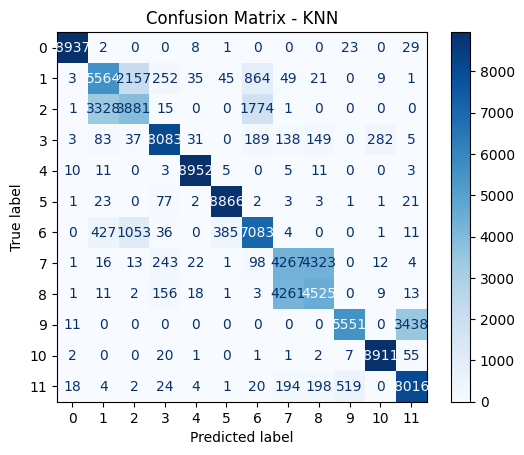

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9000
           1       0.59      0.62      0.60      9000
           2       0.54      0.43      0.48      9000
           3       0.91      0.90      0.90      9000
           4       0.99      0.99      0.99      9000
           5       0.95      0.99      0.97      9000
           6       0.71      0.79      0.74      9000
           7       0.48      0.47      0.48      9000
           8       0.49      0.50      0.50      9000
           9       0.91      0.62      0.74      9000
          10       0.97      0.99      0.98      9000
          11       0.69      0.89      0.78      9000

    accuracy                           0.77    108000
   macro avg       0.77      0.77      0.76    108000
weighted avg       0.77      0.77      0.76    108000



In [38]:
# KNN
start_train = time.time()

knn = KNeighborsClassifier(n_neighbors=33)
knn.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (KNN): {training_time:.4f} detik")

evaluate_model(knn, X_test_selected_scaled, y_test, name="KNN")

Waktu pelatihan (KNN): 0.0215 detik
Waktu prediksi (KNN): 14.1304 detik


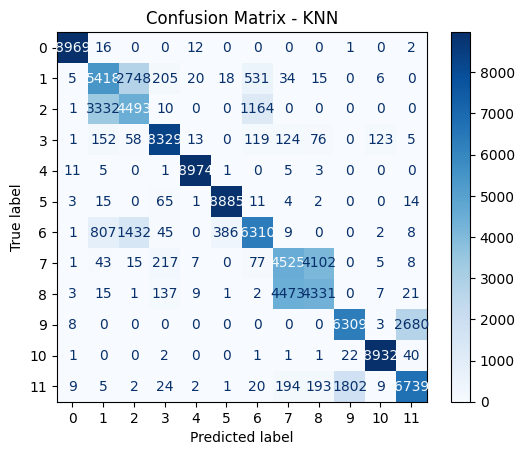

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.55      0.60      0.58      9000
           2       0.51      0.50      0.51      9000
           3       0.92      0.93      0.92      9000
           4       0.99      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.77      0.70      0.73      9000
           7       0.48      0.50      0.49      9000
           8       0.50      0.48      0.49      9000
           9       0.78      0.70      0.74      9000
          10       0.98      0.99      0.99      9000
          11       0.71      0.75      0.73      9000

    accuracy                           0.76    108000
   macro avg       0.76      0.76      0.76    108000
weighted avg       0.76      0.76      0.76    108000



In [55]:
# KNN
start_train = time.time()

knn = KNeighborsClassifier()
knn.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (KNN): {training_time:.4f} detik")

evaluate_model(knn, X_test_selected_scaled, y_test, name="KNN")

##### XGBoost

Waktu pelatihan (XGBoost): 10.5318 detik
Waktu prediksi (XGBoost): 0.2757 detik


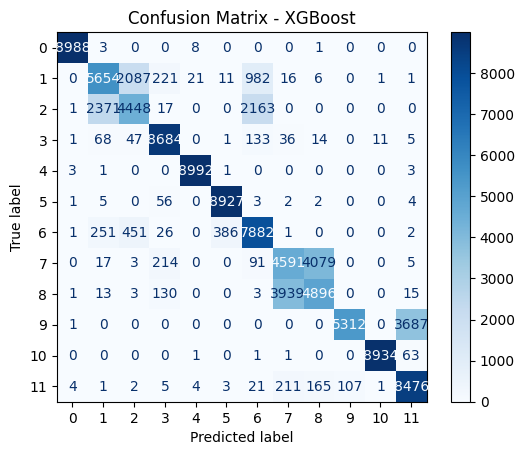

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.67      0.63      0.65      9000
           2       0.63      0.49      0.55      9000
           3       0.93      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.52      0.51      0.52      9000
           8       0.53      0.54      0.54      9000
           9       0.98      0.59      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.94      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [25]:
# XGBoost
start_train = time.time()

xgBoost = xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42)
xgBoost.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (XGBoost): {training_time:.4f} detik")

evaluate_model(xgBoost, X_test_selected_scaled, y_test, name="XGBoost")

Waktu pelatihan (XGBoost): 9.3257 detik
Waktu prediksi (XGBoost): 0.2716 detik


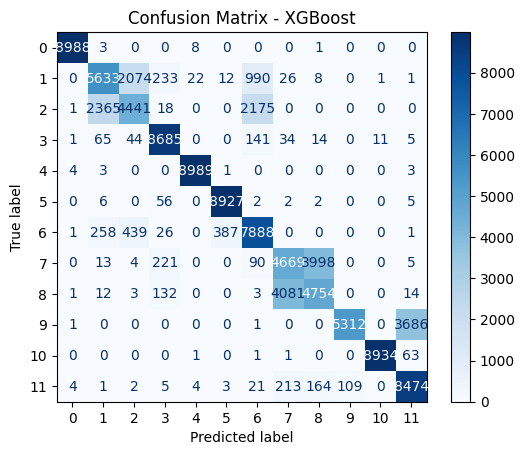

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.67      0.63      0.65      9000
           2       0.63      0.49      0.55      9000
           3       0.93      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.52      0.52      0.52      9000
           8       0.53      0.53      0.53      9000
           9       0.98      0.59      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.94      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [41]:
# XGBoost
start_train = time.time()

xgBoost = xgb.XGBClassifier(tree_method="hist", learning_rate= 0.1, max_depth= 5, n_estimators= 200, reg_lambda= 2, random_state=42)
xgBoost.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (XGBoost): {training_time:.4f} detik")

evaluate_model(xgBoost, X_test_selected_scaled, y_test, name="XGBoost")

Waktu pelatihan (XGBoost): 5.5882 detik
Waktu prediksi (XGBoost): 0.2332 detik


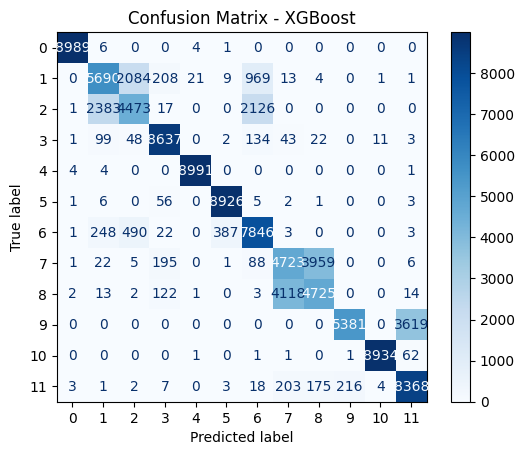

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.67      0.63      0.65      9000
           2       0.63      0.50      0.56      9000
           3       0.93      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.87      0.78      9000
           7       0.52      0.52      0.52      9000
           8       0.53      0.53      0.53      9000
           9       0.96      0.60      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.93      0.79      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [56]:
# XGBoost
start_train = time.time()

xgBoost = xgb.XGBClassifier(tree_method="hist")
xgBoost.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (XGBoost): {training_time:.4f} detik")

evaluate_model(xgBoost, X_test_selected_scaled, y_test, name="XGBoost")

##### DT

In [33]:
# Training model
model = DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42)
model.fit(X_train_selected_scaled, y_train)

# Inference 10 sampel pertama (X_test_scaled adalah NumPy array)
inference_times = []
predictions = []

for i in range(10):
    sample = X_test_selected_scaled[i].reshape(1, -1)  # ambil satu sampel, ubah jadi 2D array
    start = time.perf_counter()
    pred = model.predict(sample)
    end = time.perf_counter()

    inference_time = end - start
    inference_times.append(inference_time)
    predictions.append(pred[0])

# Tampilkan hasil
for i, (pred, t) in enumerate(zip(predictions, inference_times)):
    print(f"Sampel ke-{i+1}: Prediksi = {pred}, Waktu inferensi = {t:.6f} detik")

# Rata-rata waktu
print(f"\nRata-rata waktu inferensi: {np.mean(inference_times):.6f} detik")

Sampel ke-1: Prediksi = 7, Waktu inferensi = 0.000269 detik
Sampel ke-2: Prediksi = 7, Waktu inferensi = 0.000097 detik
Sampel ke-3: Prediksi = 0, Waktu inferensi = 0.000070 detik
Sampel ke-4: Prediksi = 9, Waktu inferensi = 0.000059 detik
Sampel ke-5: Prediksi = 2, Waktu inferensi = 0.000059 detik
Sampel ke-6: Prediksi = 4, Waktu inferensi = 0.000055 detik
Sampel ke-7: Prediksi = 1, Waktu inferensi = 0.000054 detik
Sampel ke-8: Prediksi = 3, Waktu inferensi = 0.000054 detik
Sampel ke-9: Prediksi = 3, Waktu inferensi = 0.000053 detik
Sampel ke-10: Prediksi = 9, Waktu inferensi = 0.000072 detik

Rata-rata waktu inferensi: 0.000084 detik


In [32]:
# Training model
model = DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42)
model.fit(X_train_selected_scaled, y_train)

# Inference 10 sampel pertama (X_test_scaled adalah NumPy array)
inference_times = []
predictions = []

for i in range(10):
    sample = X_test_selected_scaled[i].reshape(1, -1)  # ambil satu sampel, ubah jadi 2D array
    start = time.time()
    pred = model.predict(sample)
    end = time.time()

    inference_time = end - start
    inference_times.append(inference_time)
    predictions.append(pred[0])

# Tampilkan hasil
for i, (pred, t) in enumerate(zip(predictions, inference_times)):
    print(f"Sampel ke-{i+1}: Prediksi = {pred}, Waktu inferensi = {t:.6f} detik")

# Rata-rata waktu
print(f"\nRata-rata waktu inferensi: {np.mean(inference_times):.6f} detik")

Sampel ke-1: Prediksi = 7, Waktu inferensi = 0.019513 detik
Sampel ke-2: Prediksi = 7, Waktu inferensi = 0.000000 detik
Sampel ke-3: Prediksi = 0, Waktu inferensi = 0.000000 detik
Sampel ke-4: Prediksi = 9, Waktu inferensi = 0.000000 detik
Sampel ke-5: Prediksi = 2, Waktu inferensi = 0.000000 detik
Sampel ke-6: Prediksi = 4, Waktu inferensi = 0.000510 detik
Sampel ke-7: Prediksi = 1, Waktu inferensi = 0.000000 detik
Sampel ke-8: Prediksi = 3, Waktu inferensi = 0.000000 detik
Sampel ke-9: Prediksi = 3, Waktu inferensi = 0.000000 detik
Sampel ke-10: Prediksi = 9, Waktu inferensi = 0.000000 detik

Rata-rata waktu inferensi: 0.002002 detik


Waktu pelatihan (Decision Tree): 2.0151 detik
Waktu prediksi (Decision Tree): 0.0191 detik


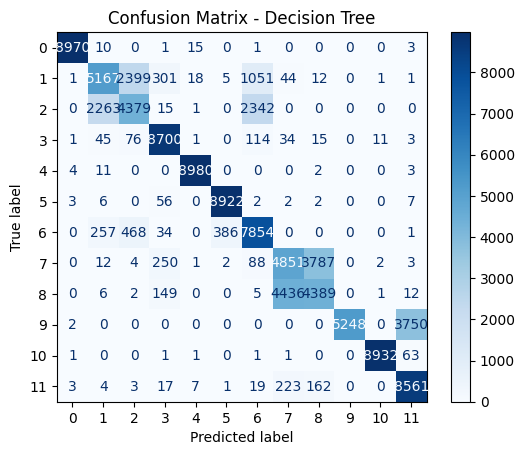

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.66      0.57      0.62      9000
           2       0.60      0.49      0.54      9000
           3       0.91      0.97      0.94      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.68      0.87      0.77      9000
           7       0.51      0.54      0.52      9000
           8       0.52      0.49      0.51      9000
           9       1.00      0.58      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.79      0.79      0.78    108000
weighted avg       0.79      0.79      0.78    108000



In [39]:
# Decision Tree
start_train = time.time()

dt = DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42)
dt.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Decision Tree): {training_time:.4f} detik")

evaluate_model(dt, X_test_selected_scaled, y_test, name="Decision Tree")

Waktu pelatihan (Decision Tree): 2.6908 detik
Waktu prediksi (Decision Tree): 0.0358 detik


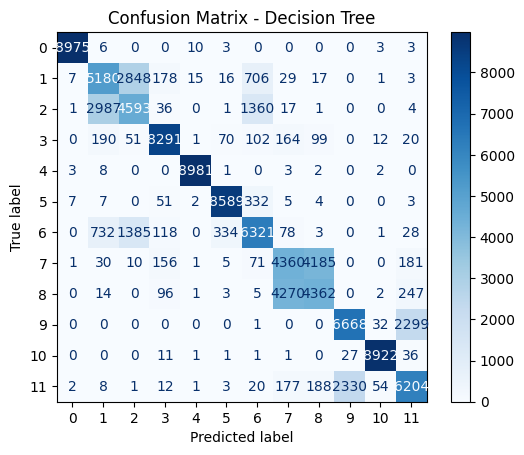

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.57      0.58      0.57      9000
           2       0.52      0.51      0.51      9000
           3       0.93      0.92      0.92      9000
           4       1.00      1.00      1.00      9000
           5       0.95      0.95      0.95      9000
           6       0.71      0.70      0.71      9000
           7       0.48      0.48      0.48      9000
           8       0.49      0.48      0.49      9000
           9       0.74      0.74      0.74      9000
          10       0.99      0.99      0.99      9000
          11       0.69      0.69      0.69      9000

    accuracy                           0.75    108000
   macro avg       0.75      0.75      0.75    108000
weighted avg       0.75      0.75      0.75    108000



In [58]:
# Decision Tree
start_train = time.time()

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Decision Tree): {training_time:.4f} detik")

evaluate_model(dt, X_test_selected_scaled, y_test, name="Decision Tree")

##### RandomForest

Waktu pelatihan (Random Forest): 99.3813 detik
Waktu prediksi (Random Forest): 3.6736 detik


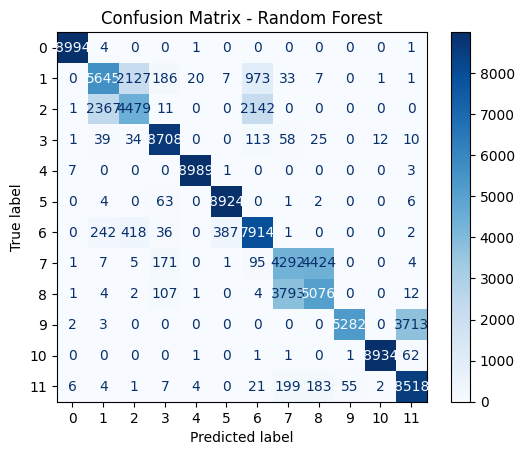

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.68      0.63      0.65      9000
           2       0.63      0.50      0.56      9000
           3       0.94      0.97      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.88      0.78      9000
           7       0.51      0.48      0.49      9000
           8       0.52      0.56      0.54      9000
           9       0.99      0.59      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.79    108000
weighted avg       0.80      0.79      0.79    108000



In [42]:
# Random Forest
start_train = time.time()

rf = RandomForestClassifier(max_depth= 20, max_features= 'sqrt', min_samples_leaf= 4, n_estimators= 300, random_state=42)
rf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Random Forest): {training_time:.4f} detik")

evaluate_model(rf, X_test_selected_scaled, y_test, name="Random Forest")

Waktu pelatihan (Random Forest): 45.3665 detik
Waktu prediksi (Random Forest): 2.5208 detik


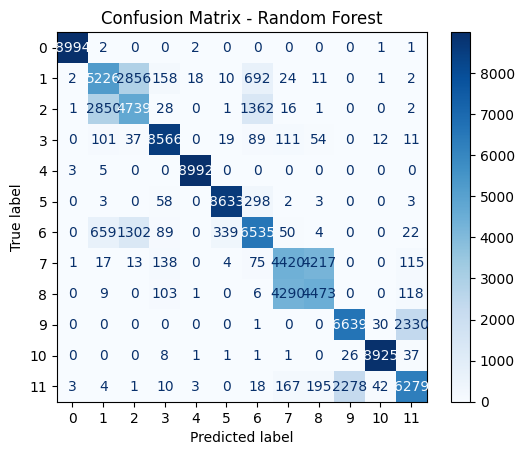

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.59      0.58      0.58      9000
           2       0.53      0.53      0.53      9000
           3       0.94      0.95      0.94      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.96      0.96      9000
           6       0.72      0.73      0.72      9000
           7       0.49      0.49      0.49      9000
           8       0.50      0.50      0.50      9000
           9       0.74      0.74      0.74      9000
          10       0.99      0.99      0.99      9000
          11       0.70      0.70      0.70      9000

    accuracy                           0.76    108000
   macro avg       0.76      0.76      0.76    108000
weighted avg       0.76      0.76      0.76    108000



In [59]:
# Random Forest
start_train = time.time()

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Random Forest): {training_time:.4f} detik")

evaluate_model(rf, X_test_selected_scaled, y_test, name="Random Forest")

##### Naive Bayes

Waktu pelatihan (Naive Bayes): 0.0956 detik
Waktu prediksi (Naive Bayes): 0.2446 detik


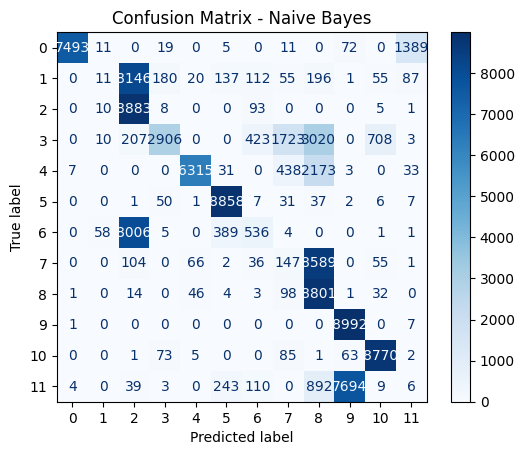

              precision    recall  f1-score   support

           0       1.00      0.83      0.91      9000
           1       0.11      0.00      0.00      9000
           2       0.35      0.99      0.52      9000
           3       0.90      0.32      0.47      9000
           4       0.98      0.70      0.82      9000
           5       0.92      0.98      0.95      9000
           6       0.41      0.06      0.10      9000
           7       0.06      0.02      0.03      9000
           8       0.37      0.98      0.54      9000
           9       0.53      1.00      0.70      9000
          10       0.91      0.97      0.94      9000
          11       0.00      0.00      0.00      9000

    accuracy                           0.57    108000
   macro avg       0.54      0.57      0.50    108000
weighted avg       0.54      0.57      0.50    108000



In [43]:
# Naive Bayes
start_train = time.time()

nb = GaussianNB(var_smoothing= np.float64(0.01))
nb.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Naive Bayes): {training_time:.4f} detik")

evaluate_model(nb, X_test_selected_scaled, y_test, name="Naive Bayes")

Waktu pelatihan (Naive Bayes): 0.0822 detik
Waktu prediksi (Naive Bayes): 0.1689 detik


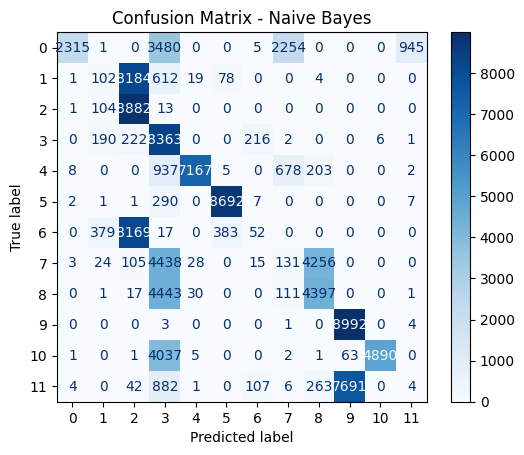

              precision    recall  f1-score   support

           0       0.99      0.26      0.41      9000
           1       0.13      0.01      0.02      9000
           2       0.35      0.99      0.51      9000
           3       0.30      0.93      0.46      9000
           4       0.99      0.80      0.88      9000
           5       0.95      0.97      0.96      9000
           6       0.13      0.01      0.01      9000
           7       0.04      0.01      0.02      9000
           8       0.48      0.49      0.49      9000
           9       0.54      1.00      0.70      9000
          10       1.00      0.54      0.70      9000
          11       0.00      0.00      0.00      9000

    accuracy                           0.50    108000
   macro avg       0.49      0.50      0.43    108000
weighted avg       0.49      0.50      0.43    108000



In [61]:
# Naive Bayes
start_train = time.time()

nb = GaussianNB()
nb.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Naive Bayes): {training_time:.4f} detik")

evaluate_model(nb, X_test_selected_scaled, y_test, name="Naive Bayes")

##### SVM

Waktu pelatihan (SVM): 531.7618 detik
Waktu prediksi (SVM): 1022.6473 detik
accuracy: 0.727175925925926
precision: 0.7344664621040037
recall: 0.727175925925926
f1-score: 0.698865644083697


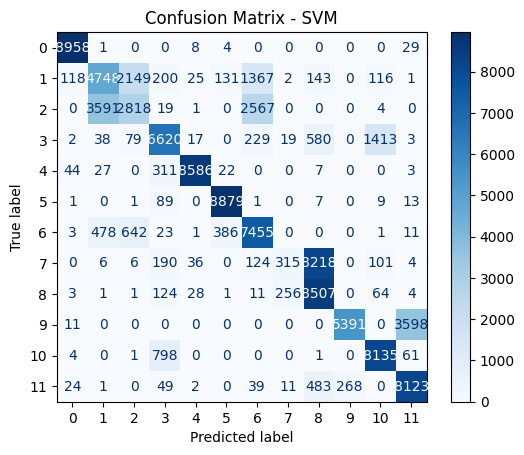

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9000
           1       0.53      0.53      0.53      9000
           2       0.49      0.31      0.38      9000
           3       0.79      0.74      0.76      9000
           4       0.99      0.95      0.97      9000
           5       0.94      0.99      0.96      9000
           6       0.63      0.83      0.72      9000
           7       0.52      0.04      0.07      9000
           8       0.47      0.95      0.63      9000
           9       0.95      0.60      0.74      9000
          10       0.83      0.90      0.86      9000
          11       0.69      0.90      0.78      9000

    accuracy                           0.73    108000
   macro avg       0.73      0.73      0.70    108000
weighted avg       0.73      0.73      0.70    108000



In [26]:
# SVM
start_train = time.time()

svm = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (SVM): {training_time:.4f} detik")

evaluate_model_2(svm, X_test_selected_scaled, y_test, name="SVM") 

Waktu pelatihan (SVM): 505.8228 detik
Waktu prediksi (SVM): 973.1247 detik


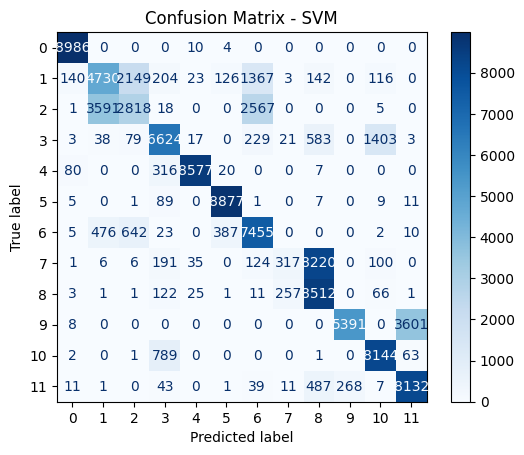

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      9000
           1       0.53      0.53      0.53      9000
           2       0.49      0.31      0.38      9000
           3       0.79      0.74      0.76      9000
           4       0.99      0.95      0.97      9000
           5       0.94      0.99      0.96      9000
           6       0.63      0.83      0.72      9000
           7       0.52      0.04      0.07      9000
           8       0.47      0.95      0.63      9000
           9       0.95      0.60      0.74      9000
          10       0.83      0.90      0.86      9000
          11       0.69      0.90      0.78      9000

    accuracy                           0.73    108000
   macro avg       0.73      0.73      0.70    108000
weighted avg       0.73      0.73      0.70    108000



In [62]:
# SVM
start_train = time.time()

svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_selected_scaled, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (SVM): {training_time:.4f} detik")

evaluate_model(svm, X_test_selected_scaled, y_test, name="SVM")

### Tanpa Classfication Report

In [35]:
import joblib
import glob

In [ ]:
models = {
    "KNN": KNeighborsClassifier(metric= 'minkowski', n_neighbors= 9, p= 1, weights= 'uniform'),
    "NB": GaussianNB(var_smoothing=np.float64(0.01)),
    "LR": LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000),
    "DT": DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42),
    "SVM": SVC(kernel='rbf', C=1, gamma='scale', random_state=42),
    "XGB": xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42),
    "RF": RandomForestClassifier(max_depth= 20, max_features= 'sqrt', min_samples_leaf= 4, n_estimators= 300, random_state=42),
    "AB": AdaBoostClassifier(learning_rate= 0.5, n_estimators= 300, random_state=42)
}

In [45]:
# Loop semua model dan simpan satu per satu
for name, model in models.items():
    model.fit(X_train_selected_scaled, y_train)
    y_pred = model.predict(X_test_selected_scaled)

    # Save model
    filename = f'model_{name.replace(" ", "_")}.joblib'
    joblib.dump(model, f'model_training_rfe/{filename}')
    
    # Save hasil predict_proba
    np.save(f'model_training_rfe/y_pred_{name.replace(" ", "_").lower()}.npy', y_pred)
    
    print(f'Model dan hasil prediksi {name} berhasil disimpan.')

Model dan hasil prediksi KNN berhasil disimpan.
Model dan hasil prediksi NB berhasil disimpan.
Model dan hasil prediksi LR berhasil disimpan.
Model dan hasil prediksi DR berhasil disimpan.
Model dan hasil prediksi SVM berhasil disimpan.
Model dan hasil prediksi XGBt berhasil disimpan.
Model dan hasil prediksi RF berhasil disimpan.
Model dan hasil prediksi AB berhasil disimpan.


##### Based on Paper 1

In [42]:
base_learners_paper_1_1 = [
    ("LR", LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)),
    ("SVM", SVC(kernel='rbf', C=1, gamma='scale', random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("KNN", KNeighborsClassifier(metric= 'minkowski', n_neighbors= 9, p= 1, weights= 'uniform')),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42)),
    ("XGBoost", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42))
]

meta_learner_paper_1_1 = LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)

model_stacking_paper_1_1 = {
    "Stacking(true) LR+SVM+RF+KNN+DT+XGB-LR": StackingClassifier(estimators=base_learners_paper_1_1, final_estimator=meta_learner_paper_1_1, cv=3, n_jobs=-1, passthrough=True, verbose=3),
    "Stacking(false) LR+SVM+RF+KNN+DT+XGB-LR": StackingClassifier(estimators=base_learners_paper_1_1, final_estimator=meta_learner_paper_1_1, cv=3, n_jobs=-1, passthrough=False, verbose=3)
}

In [43]:
# Loop semua model dan simpan satu per satu
for name, model in model_stacking_paper_1_1.items():
    model.fit(X_train_selected_scaled, y_train)
    y_pred = model.predict(X_test_selected_scaled)

    # Save model
    filename = f'model_{name.replace(" ", "_").lower()}.joblib'
    joblib.dump(model, f'model_training_ensemble_rfe/{filename}')
    
    # Save hasil predict_proba
    np.save(f'model_training_ensemble_rfe/y_pred_{name.replace(" ", "_").lower()}.npy', y_pred)
    
    print(f'Model dan hasil prediksi {name} berhasil disimpan.')

Model dan hasil prediksi Stacking(true) LR+SVM+RF+KNN+DT+XGB-LR berhasil disimpan.
Model dan hasil prediksi Stacking(false) LR+SVM+RF+KNN+DT+XGB-LR berhasil disimpan.


In [44]:
base_learners_paper_1_2 = [
    ("LR", LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)),
    ("SVM", SVC(kernel='rbf', C=1, gamma='scale', random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("KNN", KNeighborsClassifier(metric= 'minkowski', n_neighbors= 9, p= 1, weights= 'uniform')),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42)),
    ("XGBoost", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42))
]

meta_learner_paper_1_2 = xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42)

model_stacking_paper_1_2 = {
    "Stacking(true) LR+SVM+RF+KNN+DT+XGB-XGB": StackingClassifier(estimators=base_learners_paper_1_2, final_estimator=meta_learner_paper_1_2, cv=3, n_jobs=-1, passthrough=True, verbose=3),
    "Stacking(false) LR+SVM+RF+KNN+DT+XGB-XGB": StackingClassifier(estimators=base_learners_paper_1_2, final_estimator=meta_learner_paper_1_2, cv=3, n_jobs=-1, passthrough=False, verbose=3)
}

In [45]:
# Loop semua model dan simpan satu per satu
for name, model in model_stacking_paper_1_2.items():
    model.fit(X_train_selected_scaled, y_train)
    y_pred = model.predict(X_test_selected_scaled)

    # Save model
    filename = f'model_{name.replace(" ", "_").lower()}.joblib'
    joblib.dump(model, f'model_training_ensemble_rfe/{filename}')
    
    # Save hasil predict_proba
    np.save(f'model_training_ensemble_rfe/y_pred_{name.replace(" ", "_").lower()}.npy', y_pred)
    
    print(f'Model dan hasil prediksi {name} berhasil disimpan.')

Model dan hasil prediksi Stacking(true) LR+SVM+RF+KNN+DT+XGB-XGB berhasil disimpan.
Model dan hasil prediksi Stacking(false) LR+SVM+RF+KNN+DT+XGB-XGB berhasil disimpan.


##### Based on Paper 3

In [40]:
base_learners_paper_2 = [
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("XGB", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42))
]

meta_learner_paper_2 = LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)

model_stacking_paper_2 = {
    "Stacking(true) RF+XGB-LR": StackingClassifier(estimators=base_learners_paper_2, final_estimator=meta_learner_paper_2, cv=3, n_jobs=-1, passthrough=True, verbose=3),
    "Stacking(false) RF+XGB-LR": StackingClassifier(estimators=base_learners_paper_2, final_estimator=meta_learner_paper_2, cv=3, n_jobs=-1, passthrough=False, verbose=3)
}

In [ ]:
# Loop semua model dan simpan satu per satu
for name, model in model_stacking_paper_2.items():
    model.fit(X_train_selected_scaled, y_train)
    y_pred = model.predict(X_test_selected_scaled)

    # Save model
    filename = f'model_{name.replace(" ", "_").lower()}.joblib'
    joblib.dump(model, f'model_training_ensemble_rfe/{filename}')
    
    # Save hasil predict_proba
    np.save(f'model_training_ensemble_rfe/y_pred_{name.replace(" ", "_").lower()}.npy', y_pred)
    
    print(f'Model dan hasil prediksi {name} berhasil disimpan.')

##### Based on Paper 4

In [82]:
base_learners_paper_4 = [
    ("SVM", SVC(kernel='rbf', C=1, gamma='scale', random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("DT", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42)),
    ("NB", GaussianNB(var_smoothing=np.float64(0.01)))
]

# Definisikan meta learner
meta_learner_paper_4 =  LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)

model_stacking_paper_4 = {
    "stacking_4_true": StackingClassifier(estimators=base_learners_paper_4, final_estimator=meta_learner_paper_4, cv=3, n_jobs=-1, passthrough=True, verbose=3),
    "stacking_4_false": StackingClassifier(estimators=base_learners_paper_4, final_estimator=meta_learner_paper_4, cv=3, n_jobs=-1, passthrough=False, verbose=3)
}

In [84]:
# Loop semua model dan simpan satu per satu
for name, model in model_stacking_paper_4.items():
    model.fit(X_train_selected_scaled, y_train)
    y_pred = model.predict(X_test_selected_scaled)

    # Save model
    filename = f'model_{name.replace(" ", "_").lower()}.joblib'
    joblib.dump(model, f'model_training_ensemble_rfe/{filename}')
    
    # Save hasil predict_proba
    np.save(f'model_training_ensemble_rfe/y_pred_{name.replace(" ", "_").lower()}.npy', y_pred)
    
    print(f'Model dan hasil prediksi {name} berhasil disimpan.')

Model dan hasil prediksi stacking_4_true berhasil disimpan.
Model dan hasil prediksi stacking_4_false berhasil disimpan.


##### Proposed Model

In [74]:
base_learners_proposed = [
    ("XGB", xgb.XGBClassifier(tree_method="hist", gamma= 0.3, learning_rate= 0.1, max_depth= 5, n_estimators= 300, reg_alpha= 0.01, reg_lambda= 1, random_state=42)),
    ("RF", RandomForestClassifier(n_estimators=300, max_depth=20, max_features="sqrt", min_samples_leaf=4, random_state=42)),
    ("AdaBoost", AdaBoostClassifier(learning_rate= 0.5, n_estimators= 300, random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= None, min_samples_leaf= 4, min_samples_split= 2, random_state=42))
]

meta_learner_proposed= LogisticRegression(solver= 'newton-cg', penalty= None, max_iter=5000)

model_stacking_proposed = {
    "stacking_proposed_true": StackingClassifier(estimators=base_learners_proposed, final_estimator=meta_learner_proposed, cv=3, n_jobs=-1, passthrough=True, verbose=3),
    "stacking_proposed_false": StackingClassifier(estimators=base_learners_proposed, final_estimator=meta_learner_proposed, cv=3, n_jobs=-1, passthrough=False, verbose=3)
}

In [76]:
# Loop semua model dan simpan satu per satu
for name, model in model_stacking_proposed.items():
    model.fit(X_train_selected_scaled, y_train)
    y_pred = model.predict(X_test_selected_scaled)

    # Save model
    filename = f'{name.replace(" ", "_").lower()}.joblib'
    joblib.dump(model, f'model_training_ensemble_rfe/{filename}')
    
    # Save hasil predict_proba
    np.save(f'model_training_ensemble_rfe/y_pred_{name.replace(" ", "_").lower()}.npy', y_pred)
    
    print(f'Model dan hasil prediksi {name} berhasil disimpan.')

Model dan hasil prediksi stacking_proposed_true berhasil disimpan.
Model dan hasil prediksi stacking_proposed_false berhasil disimpan.


##### Evaluate Model Stacking

In [85]:
# Cari semua file .npy di folder saat ini
npy_files = glob.glob('model_training_ensemble_rfe/*.npy')
npy_files

['model_training_ensemble_rfe\\y_pred_stacking_1_false.npy',
 'model_training_ensemble_rfe\\y_pred_stacking_1_true.npy',
 'model_training_ensemble_rfe\\y_pred_stacking_2_false.npy',
 'model_training_ensemble_rfe\\y_pred_stacking_2_true.npy',
 'model_training_ensemble_rfe\\y_pred_stacking_3_false.npy',
 'model_training_ensemble_rfe\\y_pred_stacking_3_true.npy',
 'model_training_ensemble_rfe\\y_pred_stacking_4_false.npy',
 'model_training_ensemble_rfe\\y_pred_stacking_4_true.npy',
 'model_training_ensemble_rfe\\y_pred_stacking_proposed_false.npy',
 'model_training_ensemble_rfe\\y_pred_stacking_proposed_true.npy']

In [86]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# List untuk menyimpan hasil
results = []

# Loop setiap file dan warna
for file_name in (npy_files):
    
    # Ambil nama model dari nama file, buang ekstensi
    model_name = file_name.replace('model_training_ensemble_rfe\\y_pred_', '') \
                          .replace('model_training_ensemble_rfe/y_pred_', '') \
                          .replace('.npy', '') \
                          .replace('_', ' ')
    
    print(f"Processing: {model_name}")
    
    # Load hasil prediksi
    y_pred = np.load(file_name)

    # Hitung metrik evaluasi
    acc = accuracy_score(y_test, y_pred.round())
    prec = precision_score(y_test, y_pred.round(), average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred.round(), average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred.round(), average='macro', zero_division=0)

    # Tambahkan hasil ke list
    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

# Buat DataFrame dari hasil
results_df = pd.DataFrame(results)

# Tampilkan tabel hasil
print(results_df)

Processing: stacking 1 false
Processing: stacking 1 true
Processing: stacking 2 false
Processing: stacking 2 true
Processing: stacking 3 false
Processing: stacking 3 true
Processing: stacking 4 false
Processing: stacking 4 true
Processing: stacking proposed false
Processing: stacking proposed true
                     Model  Accuracy  Precision    Recall  F1 Score
0         stacking 1 false  0.788685   0.790579  0.788685  0.786689
1          stacking 1 true  0.792278   0.797266  0.792278  0.789128
2         stacking 2 false  0.793361   0.802866  0.793361  0.790695
3          stacking 2 true  0.795343   0.803539  0.795343  0.792496
4         stacking 3 false  0.795667   0.801839  0.795667  0.792174
5          stacking 3 true  0.794963   0.801222  0.794963  0.792155
6         stacking 4 false  0.786259   0.802210  0.786259  0.780489
7          stacking 4 true  0.792741   0.801211  0.792741  0.789287
8  stacking proposed false  0.796204   0.804281  0.796204  0.792532
9   stacking proposed

In [87]:
# Cari semua file .joblib di folder yang ditentukan
joblib_files = glob.glob('model_training_ensemble_rfe/*.joblib')
joblib_files

['model_training_ensemble_rfe\\model_stacking_4_false.joblib',
 'model_training_ensemble_rfe\\model_stacking_4_true.joblib',
 'model_training_ensemble_rfe\\stacking_1_false.joblib',
 'model_training_ensemble_rfe\\stacking_1_true.joblib',
 'model_training_ensemble_rfe\\stacking_2_false.joblib',
 'model_training_ensemble_rfe\\stacking_2_true.joblib',
 'model_training_ensemble_rfe\\stacking_3_false.joblib',
 'model_training_ensemble_rfe\\stacking_3_true.joblib',
 'model_training_ensemble_rfe\\stacking_proposed_false.joblib',
 'model_training_ensemble_rfe\\stacking_proposed_true.joblib']

In [88]:
# Ambil 100 sampel pertama
X_test_sampled = X_test_selected_scaled[:100]

# List untuk menyimpan hasil akhir
results = []

# Loop setiap model
for file_name in joblib_files:
    # Ambil nama model dari nama file
    model_name = file_name.replace('model_training_ensemble_rfe\\', '') \
                          .replace('model_training_ensemble_rfe/', '') \
                          .replace('.joblib', '') \
                          .replace('_', ' ')

    print(f"\n🔍 Memproses model: {model_name}")

    # Load model
    model = joblib.load(file_name)

    # List untuk simpan waktu inference per sampel
    inference_times = []
    predictions = []

    # Loop untuk prediksi per sampel
    for i in range(len(X_test_sampled)):
        sample = X_test_sampled[i].reshape(1, -1)  # pastikan 2D
        start = time.perf_counter()
        pred = model.predict(sample)
        end = time.perf_counter()

        inference_time = (end - start) * 1000
        inference_times.append(inference_time)
        predictions.append(pred[0])

        print(f"Sampel ke-{i+1}: Prediksi = {pred[0]}, Waktu inferensi = {inference_time:.6f} ms")

    # Hitung rata-rata waktu inferensi
    avg_inference_time = np.mean(inference_times)

    # Simpan ke results
    results.append({
        'Model': model_name,
        'Rata-rata Waktu Inferensi (ms)': avg_inference_time
    })

# Buat DataFrame dari hasil
results_df = pd.DataFrame(results)


🔍 Memproses model: model stacking 4 false
Sampel ke-1: Prediksi = 8, Waktu inferensi = 21.108300 ms
Sampel ke-2: Prediksi = 8, Waktu inferensi = 17.395900 ms
Sampel ke-3: Prediksi = 0, Waktu inferensi = 19.164100 ms
Sampel ke-4: Prediksi = 9, Waktu inferensi = 21.005700 ms
Sampel ke-5: Prediksi = 2, Waktu inferensi = 19.853600 ms
Sampel ke-6: Prediksi = 4, Waktu inferensi = 24.096900 ms
Sampel ke-7: Prediksi = 2, Waktu inferensi = 24.379100 ms
Sampel ke-8: Prediksi = 3, Waktu inferensi = 23.387600 ms
Sampel ke-9: Prediksi = 3, Waktu inferensi = 20.365900 ms
Sampel ke-10: Prediksi = 9, Waktu inferensi = 21.880900 ms
Sampel ke-11: Prediksi = 5, Waktu inferensi = 24.570900 ms
Sampel ke-12: Prediksi = 11, Waktu inferensi = 19.018400 ms
Sampel ke-13: Prediksi = 4, Waktu inferensi = 22.602400 ms
Sampel ke-14: Prediksi = 8, Waktu inferensi = 19.266600 ms
Sampel ke-15: Prediksi = 2, Waktu inferensi = 20.477500 ms
Sampel ke-16: Prediksi = 7, Waktu inferensi = 20.767100 ms
Sampel ke-17: Prediks

In [89]:
# Tampilkan tabel hasil
print("\n📊 Hasil Rata-Rata Waktu Inferensi per Model:")
print(results_df)


📊 Hasil Rata-Rata Waktu Inferensi per Model:
                     Model  Rata-rata Waktu Inferensi (ms)
0   model stacking 4 false                       20.969769
1    model stacking 4 true                       20.976467
2         stacking 1 false                       47.988175
3          stacking 1 true                       48.480670
4         stacking 2 false                       48.259768
5          stacking 2 true                       49.719404
6         stacking 3 false                       16.281432
7          stacking 3 true                       14.954962
8  stacking proposed false                       54.337787
9   stacking proposed true                       53.051416


##### Evaluate Model Individual

In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# List untuk menyimpan hasil
results = []

# Loop setiap file dan warna
for file_name in (npy_files):
    
    # Ambil nama model dari nama file, buang ekstensi
    model_name = file_name.replace('model_training_rfe\\y_pred_', '') \
                          .replace('model_training_rfe/y_pred_', '') \
                          .replace('.npy', '') \
                          .replace('_', ' ')
    
    print(f"Processing: {model_name}")
    
    # Load hasil prediksi
    y_pred = np.load(file_name)

    # Hitung metrik evaluasi
    acc = accuracy_score(y_test, y_pred.round())
    prec = precision_score(y_test, y_pred.round(), average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred.round(), average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred.round(), average='macro', zero_division=0)

    # Tambahkan hasil ke list
    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

# Buat DataFrame dari hasil
results_df = pd.DataFrame(results)

# Tampilkan tabel hasil
print(results_df)

Processing: adaboost
Processing: decision tree
Processing: knn
Processing: logistic regression
Processing: naive bayes
Processing: random forest
Processing: xgboost
                 Model  Accuracy  Precision    Recall  F1 Score
0             adaboost  0.647472   0.658054  0.647472  0.620452
1        decision tree  0.786602   0.794076  0.786602  0.782152
2                  knn  0.765148   0.767767  0.765148  0.762269
3  logistic regression  0.663037   0.670713  0.663037  0.652296
4          naive bayes  0.571463   0.544201  0.571463  0.497789
5        random forest  0.794028   0.801516  0.794028  0.790069
6              xgboost  0.793463   0.800140  0.793463  0.789462


##### Evaluate Inference Time

In [63]:
# Cari semua file .joblib di folder yang ditentukan
joblib_files = glob.glob('model_training_rfe/*.joblib')
joblib_files

['model_training_rfe\\model_AB.joblib',
 'model_training_rfe\\model_DT.joblib',
 'model_training_rfe\\model_KNN.joblib',
 'model_training_rfe\\model_LR.joblib',
 'model_training_rfe\\model_NB.joblib',
 'model_training_rfe\\model_RF.joblib',
 'model_training_rfe\\model_SVM.joblib',
 'model_training_rfe\\model_XGB.joblib']

In [68]:
# Ambil 100 sampel pertama
X_test_sampled = X_test_selected_scaled[:100]

# List untuk menyimpan hasil akhir
results = []

# Loop setiap model
for file_name in joblib_files:
    # Ambil nama model dari nama file
    model_name = file_name.replace('model_training_rfe\\', '') \
                          .replace('model_training_rfe/', '') \
                          .replace('.joblib', '') \
                          .replace('_', ' ')

    print(f"\n🔍 Memproses model: {model_name}")

    # Load model
    model = joblib.load(file_name)

    # List untuk simpan waktu inference per sampel
    inference_times = []
    predictions = []

    # Loop untuk prediksi per sampel
    for i in range(len(X_test_sampled)):
        sample = X_test_sampled[i].reshape(1, -1)  # pastikan 2D
        start = time.perf_counter()
        pred = model.predict(sample)
        end = time.perf_counter()

        inference_time = (end - start) * 1000
        inference_times.append(inference_time)
        predictions.append(pred[0])

        print(f"Sampel ke-{i+1}: Prediksi = {pred[0]}, Waktu inferensi = {inference_time:.6f} ms")

    # Hitung rata-rata waktu inferensi
    avg_inference_time = np.mean(inference_times)

    # Simpan ke results
    results.append({
        'Model': model_name,
        'Rata-rata Waktu Inferensi (ms)': avg_inference_time
    })

# Buat DataFrame dari hasil
results_df = pd.DataFrame(results)


🔍 Memproses model: model AB
Sampel ke-1: Prediksi = 8, Waktu inferensi = 24.225200 ms
Sampel ke-2: Prediksi = 8, Waktu inferensi = 21.396200 ms
Sampel ke-3: Prediksi = 0, Waktu inferensi = 20.972700 ms
Sampel ke-4: Prediksi = 9, Waktu inferensi = 21.724100 ms
Sampel ke-5: Prediksi = 2, Waktu inferensi = 21.532000 ms
Sampel ke-6: Prediksi = 4, Waktu inferensi = 27.602100 ms
Sampel ke-7: Prediksi = 2, Waktu inferensi = 22.423200 ms
Sampel ke-8: Prediksi = 3, Waktu inferensi = 24.843100 ms
Sampel ke-9: Prediksi = 3, Waktu inferensi = 33.135500 ms
Sampel ke-10: Prediksi = 9, Waktu inferensi = 24.867900 ms
Sampel ke-11: Prediksi = 5, Waktu inferensi = 22.582900 ms
Sampel ke-12: Prediksi = 9, Waktu inferensi = 23.837500 ms
Sampel ke-13: Prediksi = 4, Waktu inferensi = 22.994000 ms
Sampel ke-14: Prediksi = 7, Waktu inferensi = 23.490200 ms
Sampel ke-15: Prediksi = 6, Waktu inferensi = 24.738000 ms
Sampel ke-16: Prediksi = 7, Waktu inferensi = 21.736200 ms
Sampel ke-17: Prediksi = 6, Waktu in

In [69]:
# Tampilkan tabel hasil
print("\n📊 Hasil Rata-Rata Waktu Inferensi per Model:")
print(results_df)


📊 Hasil Rata-Rata Waktu Inferensi per Model:
       Model  Rata-rata Waktu Inferensi (ms)
0   model AB                       23.164916
1   model DT                        0.073847
2  model KNN                        7.556800
3   model LR                        0.127300
4   model NB                        0.504133
5   model RF                        8.510874
6  model SVM                       11.458789
7  model XGB                        0.788972


In [65]:
# Tampilkan tabel hasil
print("\n📊 Hasil Rata-Rata Waktu Inferensi per Model:")
print(results_df)


📊 Hasil Rata-Rata Waktu Inferensi per Model:
       Model  Rata-rata Waktu Inferensi (detik)
0   model AB                           0.025014
1   model DT                           0.000089
2  model KNN                           0.008100
3   model LR                           0.000110
4   model NB                           0.000323
5   model RF                           0.008926
6  model SVM                           0.011694
7  model XGB                           0.000476


### Hyperparameter

##### Adaboost

In [27]:
adaboost = AdaBoostClassifier(random_state=42)

# Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5, 1]
}

# Mendefinisikan dan melakukan proses grid search menggunakan 3-fold cross validation dengan evaluasi yang dilihat adalah skor akurasi.
grid = GridSearchCV(adaboost, param_grid, verbose=3, cv=3, scoring='accuracy')
model_grid = grid.fit(X_train_selected_scaled, y_train)

# Menampilkan kombinasi nilai hyperparameter terbaik dan nilai akurasinya
print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END learning_rate=0.01, n_estimators=100;, score=0.256 total time=  14.7s
[CV 2/3] END learning_rate=0.01, n_estimators=100;, score=0.326 total time=  14.1s
[CV 3/3] END learning_rate=0.01, n_estimators=100;, score=0.327 total time=  14.3s
[CV 1/3] END learning_rate=0.01, n_estimators=200;, score=0.327 total time=  28.6s
[CV 2/3] END learning_rate=0.01, n_estimators=200;, score=0.327 total time=  28.2s
[CV 3/3] END learning_rate=0.01, n_estimators=200;, score=0.327 total time=  28.4s
[CV 1/3] END learning_rate=0.01, n_estimators=300;, score=0.327 total time=  43.0s
[CV 2/3] END learning_rate=0.01, n_estimators=300;, score=0.326 total time=  42.6s
[CV 3/3] END learning_rate=0.01, n_estimators=300;, score=0.324 total time=  42.7s
[CV 1/3] END learning_rate=0.1, n_estimators=100;, score=0.249 total time=  14.0s
[CV 2/3] END learning_rate=0.1, n_estimators=100;, score=0.398 total time=  14.3s
[CV 3/3] END learning_rate=0

##### XGBoost

In [ ]:
xgb_grid =  xgb.XGBClassifier(tree_method="hist")

# Pilihan nilai untuk tiap hyperparameter yang akan di-tuning
gr_space = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.01, 0.1],
    'gamma': [0.1, 0.3],
    'reg_alpha': [0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# Mendefinisikan dan melakukan proses grid search menggunakan 3-fold cross validation dengan evaluasi yang dilihat adalah skor akurasi.
grid = GridSearchCV(xgb_grid, gr_space, verbose=3, cv=3, scoring='accuracy')
model_grid = grid.fit(X_train_selected_scaled, y_train)

# Menampilkan kombinasi nilai hyperparameter terbaik dan nilai akurasinya
print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV 1/3] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1;, score=0.781 total time=   3.7s
[CV 2/3] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1;, score=0.778 total time=   3.2s
[CV 3/3] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1;, score=0.780 total time=   3.4s
[CV 1/3] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1.5;, score=0.780 total time=   3.0s
[CV 2/3] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1.5;, score=0.778 total time=   3.0s
[CV 3/3] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=1.5;, score=0.780 total time=   3.2s
[CV 1/3] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=100, reg_alpha=0.01, reg_lambda=2;, sco

##### Random Forest

In [25]:
# Hyperparameter tuning akan menggunakan random forest classifier
rf_grid = RandomForestClassifier(random_state=42)

# Pilihan nilai untuk tiap hyperparameter yang akan di-tuning
param_grid_rf = {
    'max_depth': [None, 5, 10, 20, 30],
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4]
}

# Mendefinisikan dan melakukan proses grid search menggunakan 3-fold cross validation dengan evaluasi yang dilihat adalah skor akurasi.
grid_rf = GridSearchCV(estimator=rf_grid, param_grid=param_grid_rf, cv = 3, scoring='accuracy', verbose = 3)
grid_rf.fit(X_train_selected_scaled, y_train)

# Menampilkan kombinasi nilai hyperparameter terbaik dan nilai akurasinya
print('Best hyperparameters are '+str(grid_rf.best_params_))
print('Best score is: ' + str(grid_rf.best_score_))

Fitting 3 folds for each of 135 candidates, totalling 405 fits
[CV 1/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100;, score=0.764 total time= 2.1min
[CV 2/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100;, score=0.761 total time= 2.3min
[CV 3/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100;, score=0.764 total time= 2.2min
[CV 1/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=200;, score=0.764 total time= 4.4min
[CV 2/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=200;, score=0.762 total time= 4.0min
[CV 3/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=200;, score=0.764 total time= 4.0min
[CV 1/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=300;, score=0.764 total time= 6.3min
[CV 2/3] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=300;, score=0.762 total time= 

##### kNN

In [ ]:
knn_grid = KNeighborsClassifier()

# Pilihan nilai untuk tiap hyperparameter yang akan di-tuning
gr_space = {
    'n_neighbors': range(5,21,1),
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski'],
    'p': [1, 2]  # 1=Manhattan, 2=Euclidean
}

# Mendefinisikan dan melakukan proses grid search menggunakan 3-fold cross validation dengan evaluasi yang dilihat adalah skor akurasi.
grid = GridSearchCV(knn_grid, gr_space, verbose = 3, cv = 3, scoring='accuracy')
model_grid = grid.fit(X_train_selected_scaled, y_train)

# Menampilkan kombinasi nilai hyperparameter terbaik dan nilai akurasinya
print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

In [25]:
knn_grid = KNeighborsClassifier()

# Pilihan nilai untuk tiap hyperparameter yang akan di-tuning
gr_space = {
    'n_neighbors': range(5,11,1),
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski'],
    'p': [1, 2]  # 1=Manhattan, 2=Euclidean
}

# Mendefinisikan dan melakukan proses grid search menggunakan 3-fold cross validation dengan evaluasi yang dilihat adalah skor akurasi.
grid = GridSearchCV(knn_grid, gr_space, verbose = 3, cv = 3, scoring='accuracy')
model_grid = grid.fit(X_train_selected_scaled, y_train)

# Menampilkan kombinasi nilai hyperparameter terbaik dan nilai akurasinya
print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END metric=minkowski, n_neighbors=5, p=1, weights=uniform;, score=0.760 total time=  21.1s
[CV 2/3] END metric=minkowski, n_neighbors=5, p=1, weights=uniform;, score=0.759 total time=  22.5s
[CV 3/3] END metric=minkowski, n_neighbors=5, p=1, weights=uniform;, score=0.759 total time=  22.3s
[CV 1/3] END metric=minkowski, n_neighbors=5, p=1, weights=distance;, score=0.754 total time=  23.5s
[CV 2/3] END metric=minkowski, n_neighbors=5, p=1, weights=distance;, score=0.754 total time=  23.1s
[CV 3/3] END metric=minkowski, n_neighbors=5, p=1, weights=distance;, score=0.752 total time=  22.7s
[CV 1/3] END metric=minkowski, n_neighbors=5, p=2, weights=uniform;, score=0.757 total time=   7.1s
[CV 2/3] END metric=minkowski, n_neighbors=5, p=2, weights=uniform;, score=0.756 total time=   7.1s
[CV 3/3] END metric=minkowski, n_neighbors=5, p=2, weights=uniform;, score=0.756 total time=   7.3s
[CV 1/3] END metric=minkowski, n_nei

In [25]:
knn_grid = KNeighborsClassifier()

# Pilihan nilai untuk tiap hyperparameter yang akan di-tuning
gr_space = {
    'n_neighbors': range(1,51,1)
}

# Mendefinisikan dan melakukan proses grid search menggunakan 3-fold cross validation dengan evaluasi yang dilihat adalah skor akurasi.
grid = GridSearchCV(knn_grid, gr_space, verbose = 3, cv = 3, scoring='accuracy')
model_grid = grid.fit(X_train_selected_scaled, y_train)

# Menampilkan kombinasi nilai hyperparameter terbaik dan nilai akurasinya
print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END .....................n_neighbors=1;, score=0.743 total time=   8.9s
[CV 2/3] END .....................n_neighbors=1;, score=0.742 total time=   8.3s
[CV 3/3] END .....................n_neighbors=1;, score=0.741 total time=   8.2s
[CV 1/3] END .....................n_neighbors=2;, score=0.742 total time=   8.4s
[CV 2/3] END .....................n_neighbors=2;, score=0.742 total time=   8.2s
[CV 3/3] END .....................n_neighbors=2;, score=0.742 total time=   8.3s
[CV 1/3] END .....................n_neighbors=3;, score=0.754 total time=   8.3s
[CV 2/3] END .....................n_neighbors=3;, score=0.753 total time=   8.2s
[CV 3/3] END .....................n_neighbors=3;, score=0.754 total time=   8.2s
[CV 1/3] END .....................n_neighbors=4;, score=0.752 total time=   8.2s
[CV 2/3] END .....................n_neighbors=4;, score=0.751 total time=   8.3s
[CV 3/3] END .....................n_neighbors=4

In [26]:
knn_grid = KNeighborsClassifier()

# Pilihan nilai untuk tiap hyperparameter yang akan di-tuning
gr_space = {
    'n_neighbors': range(1,41,1)
}

# Mendefinisikan dan melakukan proses grid search menggunakan 3-fold cross validation dengan evaluasi yang dilihat adalah skor akurasi.
grid = GridSearchCV(knn_grid, gr_space, verbose = 3, cv = 3, scoring='accuracy')
model_grid = grid.fit(X_train_selected_scaled, y_train)

# Menampilkan kombinasi nilai hyperparameter terbaik dan nilai akurasinya
print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV 1/3] END .....................n_neighbors=1;, score=0.743 total time=   5.9s
[CV 2/3] END .....................n_neighbors=1;, score=0.742 total time=   5.9s
[CV 3/3] END .....................n_neighbors=1;, score=0.741 total time=   6.5s
[CV 1/3] END .....................n_neighbors=2;, score=0.742 total time=   6.6s
[CV 2/3] END .....................n_neighbors=2;, score=0.742 total time=   6.6s
[CV 3/3] END .....................n_neighbors=2;, score=0.742 total time=   6.7s
[CV 1/3] END .....................n_neighbors=3;, score=0.754 total time=   6.4s
[CV 2/3] END .....................n_neighbors=3;, score=0.753 total time=   6.6s
[CV 3/3] END .....................n_neighbors=3;, score=0.754 total time=   6.5s
[CV 1/3] END .....................n_neighbors=4;, score=0.752 total time=   6.8s
[CV 2/3] END .....................n_neighbors=4;, score=0.751 total time=   6.7s
[CV 3/3] END .....................n_neighbors=4

In [ ]:
# Hyperparameter tuning akan menggunakan random forest classifier
knn_grid = KNeighborsClassifier()

# Pilihan nilai untuk tiap hyperparameter yang akan di-tuning
gr_space = {
    'n_neighbors': range(1,41,1)
}

# Mendefinisikan dan melakukan proses grid search menggunakan 3-fold cross validation dengan evaluasi yang dilihat adalah skor akurasi.
grid = GridSearchCV(knn_grid, gr_space, verbose = 3, cv = 3, scoring='accuracy')
model_grid = grid.fit(X_train_selected_scaled, y_train)

# Menampilkan kombinasi nilai hyperparameter terbaik dan nilai akurasinya
print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV 1/3] END .....................n_neighbors=1;, score=0.743 total time=   6.6s
[CV 2/3] END .....................n_neighbors=1;, score=0.742 total time=   5.6s
[CV 3/3] END .....................n_neighbors=1;, score=0.741 total time=   5.6s
[CV 1/3] END .....................n_neighbors=2;, score=0.743 total time=   5.6s
[CV 2/3] END .....................n_neighbors=2;, score=0.742 total time=   5.7s
[CV 3/3] END .....................n_neighbors=2;, score=0.742 total time=   5.9s
[CV 1/3] END .....................n_neighbors=3;, score=0.754 total time=   5.8s
[CV 2/3] END .....................n_neighbors=3;, score=0.753 total time=   6.4s
[CV 3/3] END .....................n_neighbors=3;, score=0.754 total time=   6.4s
[CV 1/3] END .....................n_neighbors=4;, score=0.752 total time=   6.5s
[CV 2/3] END .....................n_neighbors=4;, score=0.751 total time=   6.4s
[CV 3/3] END .....................n_neighbors=4

##### Naive Bayes

In [26]:
# Pilihan nilai untuk tiap hyperparameter yang akan di-tuning
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

# Mendefinisikan dan melakukan proses grid search menggunakan 3-fold cross validation
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=3, cv=3)
nbModel_grid.fit(X_train_selected_scaled, y_train)

# Menampilkan kombinasi nilai hyperparameter terbaik dan nilai akurasinya
print('Best hyperparameters are '+str(nbModel_grid.best_params_))
print('Best score is: ' + str(nbModel_grid.best_score_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END .................var_smoothing=1.0;, score=0.429 total time=   0.1s
[CV 2/3] END .................var_smoothing=1.0;, score=0.378 total time=   0.1s
[CV 3/3] END .................var_smoothing=1.0;, score=0.370 total time=   0.1s
[CV 1/3] END ..var_smoothing=0.8111308307896871;, score=0.428 total time=   0.1s
[CV 2/3] END ..var_smoothing=0.8111308307896871;, score=0.432 total time=   0.1s
[CV 3/3] END ..var_smoothing=0.8111308307896871;, score=0.377 total time=   0.1s
[CV 1/3] END ...var_smoothing=0.657933224657568;, score=0.429 total time=   0.1s
[CV 2/3] END ...var_smoothing=0.657933224657568;, score=0.432 total time=   0.1s
[CV 3/3] END ...var_smoothing=0.657933224657568;, score=0.434 total time=   0.1s
[CV 1/3] END ...var_smoothing=0.533669923120631;, score=0.428 total time=   0.1s
[CV 2/3] END ...var_smoothing=0.533669923120631;, score=0.433 total time=   0.1s
[CV 3/3] END ...var_smoothing=0.53366992312063

##### Decision Tree

In [26]:
# 🔧 Pilihan nilai hyperparameter untuk dituning
param_grid_dt = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # fungsi pemisahan
    'max_depth': [None, 5, 10, 20, 30],             # kedalaman maksimum pohon
    'min_samples_split': [2, 5, 10],                # minimal sampel untuk split node
    'min_samples_leaf': [1, 2, 4],                  # minimal sampel di node daun
    'max_features': [None, 'sqrt', 'log2'],         # jumlah fitur yang dipakai saat split
    'random_state': [42]                            # untuk hasil konsisten
}

# 🔁 Proses grid search dengan 3-fold cross-validation
dt_grid = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=param_grid_dt,
    verbose=3,
    cv=3,
    scoring='accuracy'
)

# ⚙️ Fit ke data training (gunakan dataset Anda)
dt_grid.fit(X_train_selected_scaled, y_train)

# 🏆 Tampilkan hasil terbaik
print("Best hyperparameters:", dt_grid.best_params_)
print("Best cross-validation score (accuracy):", dt_grid.best_score_)


Fitting 3 folds for each of 405 candidates, totalling 1215 fits
[CV 1/3] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, random_state=42;, score=0.754 total time=   1.3s
[CV 2/3] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, random_state=42;, score=0.751 total time=   1.3s
[CV 3/3] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, random_state=42;, score=0.752 total time=   1.2s
[CV 1/3] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, random_state=42;, score=0.756 total time=   1.2s
[CV 2/3] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, random_state=42;, score=0.754 total time=   1.4s
[CV 3/3] END criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, random_state=42;, score=0.755 total time=   1.2s
[CV 1/3] END

##### Logreg

In [34]:
# Inisialisasi LogisticRegression untuk Multiclass
logreg = LogisticRegression(max_iter=5000)

# Parameter Grid untuk GridSearchCV
param_grid = [
    {
        'solver': ['lbfgs', 'newton-cg', 'newton-cholesky'],
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 2],
    },
    {
        'solver': ['lbfgs', 'newton-cg', 'newton-cholesky'],
        'penalty': [None]
    }
]

# GridSearch dengan Cross-Validation
grid_search = GridSearchCV(logreg, 
                           param_grid=param_grid, 
                           verbose=3, 
                           cv=3, 
                           scoring='accuracy')

# Fitting
grid_search.fit(X_train_selected_scaled, y_train)

# Hasil Terbaik
print("Best Parameters:", grid_search.best_params_)
print("Best Score (CV Accuracy):", grid_search.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.640 total time=  10.5s
[CV 2/3] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.639 total time=  10.2s
[CV 3/3] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.642 total time=  10.5s
[CV 1/3] END C=0.01, penalty=l2, solver=newton-cg;, score=0.640 total time=  11.0s
[CV 2/3] END C=0.01, penalty=l2, solver=newton-cg;, score=0.639 total time=  17.1s
[CV 3/3] END C=0.01, penalty=l2, solver=newton-cg;, score=0.642 total time=  17.2s
[CV 1/3] END C=0.01, penalty=l2, solver=newton-cholesky;, score=0.640 total time=  41.8s
[CV 2/3] END C=0.01, penalty=l2, solver=newton-cholesky;, score=0.639 total time=  44.9s
[CV 3/3] END C=0.01, penalty=l2, solver=newton-cholesky;, score=0.642 total time= 1.1min
[CV 1/3] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.657 total time=  29.7s
[CV 2/3] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.654 total time=  31.5s
[CV 3/3] END ...C=

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:576: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=7.90159e-21): result may not be accurate.
  warnings.warn(


[CV 1/3] END penalty=None, solver=newton-cholesky;, score=0.662 total time= 1.0min


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:576: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.82169e-20): result may not be accurate.
  warnings.warn(


[CV 2/3] END penalty=None, solver=newton-cholesky;, score=0.660 total time= 1.3min


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:576: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.1838e-20): result may not be accurate.
  warnings.warn(


[CV 3/3] END penalty=None, solver=newton-cholesky;, score=0.660 total time= 1.5min
Best Parameters: {'penalty': None, 'solver': 'newton-cg'}
Best Score (CV Accuracy): 0.6608492063492063


In [ ]:
# Inisialisasi LogisticRegression untuk Multiclass
logreg = LogisticRegression(max_iter=5000)

# Parameter Grid untuk GridSearchCV
param_grid = [
    {
        'solver': ['lbfgs', 'newton-cg', 'newton-cholesky'],
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 2],
    },
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 2]
    },
    {
        'solver': ['saga', 'lbfgs', 'newton-cg'],
        'penalty': [None]
    },
    {
        'solver': ['saga'],
        'penalty': ['elasticnet'],
        'C': [0.01, 0.1, 1, 2],
        'l1_ratio': [0.1, 0.5, 0.9],
    }
]

# GridSearch dengan Cross-Validation
grid_search = GridSearchCV(logreg, 
                           param_grid=param_grid, 
                           verbose=3, 
                           cv=3, 
                           scoring='accuracy')

# Fitting
grid_search.fit(X_train_selected_scaled, y_train)

# Hasil Terbaik
print("Best Parameters:", grid_search.best_params_)
print("Best Score (CV Accuracy):", grid_search.best_score_)

Fitting 3 folds for each of 35 candidates, totalling 105 fits
[CV 1/3] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.640 total time=  13.7s
[CV 2/3] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.639 total time=  10.9s
[CV 3/3] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.642 total time=   9.5s
[CV 1/3] END C=0.01, penalty=l2, solver=newton-cg;, score=0.640 total time=  11.6s
[CV 2/3] END C=0.01, penalty=l2, solver=newton-cg;, score=0.639 total time=  12.5s
[CV 3/3] END C=0.01, penalty=l2, solver=newton-cg;, score=0.642 total time=  15.7s
[CV 1/3] END C=0.01, penalty=l2, solver=newton-cholesky;, score=0.640 total time=  38.2s
[CV 2/3] END C=0.01, penalty=l2, solver=newton-cholesky;, score=0.639 total time=  31.1s
[CV 3/3] END C=0.01, penalty=l2, solver=newton-cholesky;, score=0.642 total time=  33.7s
[CV 1/3] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.657 total time=  15.8s
[CV 2/3] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.654 total time=  16.7s
[CV 3/3] END ...C

##### SVM

In [ ]:
param_grid_svm = [
    {
        'kernel': ['linear', 'rbf'],
        'C': [0.1, 0.5, 1], 
        'gamma': ['scale', 'auto']
    }
]

# 🔁 Proses grid search dengan 3-fold cross-validation
svm_grid = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid_svm,
    verbose=3,
    cv=3,
    scoring='accuracy'
)

# ⚙️ Fit ke data training (gunakan dataset Anda)
svm_grid.fit(X_train_selected_scaled, y_train)

print("Best hyperparameters:", svm_grid.best_params_)
print("Best cross-validation score (accuracy):", svm_grid.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END .C=0.1, gamma=scale, kernel=linear;, score=0.679 total time= 5.2min
[CV 2/3] END .C=0.1, gamma=scale, kernel=linear;, score=0.671 total time= 5.2min
[CV 3/3] END .C=0.1, gamma=scale, kernel=linear;, score=0.678 total time= 5.2min
[CV 1/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.694 total time=11.5min
[CV 2/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.692 total time=11.5min
[CV 3/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.694 total time=11.6min
[CV 1/3] END ..C=0.1, gamma=auto, kernel=linear;, score=0.679 total time= 5.2min
[CV 2/3] END ..C=0.1, gamma=auto, kernel=linear;, score=0.671 total time= 5.2min
[CV 3/3] END ..C=0.1, gamma=auto, kernel=linear;, score=0.678 total time= 5.3min
[CV 1/3] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.694 total time=11.5min
[CV 2/3] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.692 total time=11.6min
[CV 3/3] END .....C=0.1, gamma=auto, kernel=rbf;

In [ ]:
# 🔧 Pilihan nilai hyperparameter untuk dituning
param_grid_svm = [
    {
        'kernel': ['linear', 'rbf', 'poly'],
        'C': [0.1, 0.5, 1], 
        'gamma': ['scale']
    },
    {
        'kernel': ['linear', 'rbf'],
        'C': [0.1, 0.5, 1], 
        'gamma': ['auto']
    }
]

# 🔁 Proses grid search dengan 3-fold cross-validation
svm_grid = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid_svm,
    verbose=3,
    cv=3,
    scoring='accuracy', n_jobs=-1
)

# ⚙️ Fit ke data training (gunakan dataset Anda)
svm_grid.fit(X_train_selected_scaled, y_train)

# 🏆 Tampilkan hasil terbaik
print("Best hyperparameters:", svm_grid.best_params_)
print("Best cross-validation score (accuracy):", svm_grid.best_score_)


Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END .C=0.1, gamma=scale, kernel=linear;, score=0.679 total time= 5.5min
[CV 2/3] END .C=0.1, gamma=scale, kernel=linear;, score=0.671 total time= 5.6min
[CV 3/3] END .C=0.1, gamma=scale, kernel=linear;, score=0.678 total time= 5.6min
[CV 1/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.694 total time=11.6min
[CV 2/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.692 total time=11.6min
[CV 3/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.694 total time=11.7min
[CV 1/3] END ...C=0.1, gamma=scale, kernel=poly;, score=0.650 total time= 8.0min
[CV 2/3] END ...C=0.1, gamma=scale, kernel=poly;, score=0.651 total time= 7.9min
[CV 3/3] END ...C=0.1, gamma=scale, kernel=poly;, score=0.648 total time= 8.3min
[CV 1/3] END .C=0.5, gamma=scale, kernel=linear;, score=0.679 total time= 5.5min
[CV 2/3] END .C=0.5, gamma=scale, kernel=linear;, score=0.670 total time= 5.6min
[CV 3/3] END .C=0.5, gamma=scale, kernel=linear;

In [ ]:
# 🔧 Pilihan nilai hyperparameter untuk dituning
param_grid_svm = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 0.5, 1], 
	'gamma': ['scale', 'auto']
}

# 🔁 Proses grid search dengan 3-fold cross-validation
svm_grid = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid_svm,
    verbose=3,
    cv=3,
    scoring='accuracy'
)

# ⚙️ Fit ke data training (gunakan dataset Anda)
svm_grid.fit(X_train_selected_scaled, y_train)

# 🏆 Tampilkan hasil terbaik
print("Best hyperparameters:", svm_grid.best_params_)
print("Best cross-validation score (accuracy):", svm_grid.best_score_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END .C=0.1, gamma=scale, kernel=linear;, score=0.679 total time= 5.5min
[CV 2/3] END .C=0.1, gamma=scale, kernel=linear;, score=0.671 total time= 4.9min
[CV 3/3] END .C=0.1, gamma=scale, kernel=linear;, score=0.678 total time= 4.9min
[CV 1/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.694 total time=11.1min
[CV 2/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.692 total time=11.0min
[CV 3/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.694 total time=11.1min
[CV 1/3] END ...C=0.1, gamma=scale, kernel=poly;, score=0.650 total time= 7.3min
[CV 2/3] END ...C=0.1, gamma=scale, kernel=poly;, score=0.651 total time= 7.2min
[CV 3/3] END ...C=0.1, gamma=scale, kernel=poly;, score=0.648 total time= 7.5min
[CV 1/3] END ..C=0.1, gamma=auto, kernel=linear;, score=0.679 total time= 4.9min
[CV 2/3] END ..C=0.1, gamma=auto, kernel=linear;, score=0.671 total time= 4.9min
[CV 3/3] END ..C=0.1, gamma=auto, kernel=linear;